# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [8]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [32]:
#safety/restore
# cigData = pd.read_csv('CowboyCigsData.csv')
# cigData = cigData.drop('Unnamed: 0', axis=1)
# cigData = cigData.rename(columns={'Time':'Month'})
# cigData['Month'] = pd.to_datetime(cigData['Month'])
# cigData = cigData.set_index('Month')
# y = cigData['#CigSales']
# y_log = np.log(y)

### 1b. Load the data
Call the variable `cigData`. 

In [3]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [5]:
cigData

Unnamed: 0     Time  #CigSales
0             0  1949-01    1000112
1             1  1949-02    1000118
2             2  1949-03    1000132
3             3  1949-04    1000129
4             4  1949-05    1000121
..          ...      ...        ...
139         139  1960-08    1000606
140         140  1960-09    1000508
141         141  1960-10    1000461
142         142  1960-11    1000390
143         143  1960-12    1000432

[144 rows x 3 columns]

In [ ]:
#so cig sales for each month in this 12 year period. that's why 144 rows! 12 months x 12 years!

In [4]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

In [ ]:
#we need it to be in ACTUAL datetime format! as we learned, seems at least this will be w/ including the day of month, like full format, default at least
#will do this soon

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

In [ ]:
#oh wow yeah that number is just over/broke 1 MILLION!

Check out the columns feature of the data. How many columns are there? 

In [6]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

In [ ]:
#oh lol didn't even pay attention to / notice that 'unnamed' cuz redundant - just matches the index, representing the month in this period,
#so can just SCRAP??

#only 2 actual columns

Let's check out the data types of our columns.

In [ ]:
#did

Check whether there are any null values. 

In [9]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [ ]:
#dope so no nulls at least (could still be bogus vals/effective missings)

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [11]:
#backup/restore version/copy before we alter!
cigData_backup0 = cigData.copy()

cigData = cigData.drop('Unnamed: 0', axis=1)

In [12]:
cigData

Time  #CigSales
0    1949-01    1000112
1    1949-02    1000118
2    1949-03    1000132
3    1949-04    1000129
4    1949-05    1000121
..       ...        ...
139  1960-08    1000606
140  1960-09    1000508
141  1960-10    1000461
142  1960-11    1000390
143  1960-12    1000432

[144 rows x 2 columns]

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [15]:
#oh yeah true
#multiple ways to do
cigData = cigData.rename(columns={'Time':'Month'})
cigData

Month  #CigSales
0    1949-01    1000112
1    1949-02    1000118
2    1949-03    1000132
3    1949-04    1000129
4    1949-05    1000121
..       ...        ...
139  1960-08    1000606
140  1960-09    1000508
141  1960-10    1000461
142  1960-11    1000390
143  1960-12    1000432

[144 rows x 2 columns]

In [ ]:
#Alhamdulillah!

Call a head() to check that this has worked. 

In [ ]:
#checked

In [ ]:
# _ _ _
#^why another?

### 2c. Type conversions 

Now, doing time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [ ]:
#tho this gets kinda annoying later when wanna manipulate the series, edit etc, or like only use values and not
#index, etc

In [22]:
#ahhh there it is! thankfully the original formatting was good and it could understand it to convert it to
#official datetime format
#i wonder if there's a way to make sure like all the months are like there consecutively? well one thing is can make sure for
#like can check no DUPLICATES!
###################################################################################################################

#and then yeah - we wanna (GOTTA! for this to work good) make the datetime column the *INDEX*!!!!

cigData_backup1 = cigData.copy()


pd.to_datetime(cigData.Month) #no need to specify format arg; doesn't change it lol; maybe that's for telling it HOW TO *INTERPRET* / decode what you're giving it, in case it can't figure it out intuitively!
#note ofc this doesn't SAVE/OVERWRITE it, just for VIEWING!

0     1949-01-01
1     1949-02-01
2     1949-03-01
3     1949-04-01
4     1949-05-01
         ...    
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: Month, Length: 144, dtype: datetime64[ns]

In [ ]:
cigData['Month'] = pd.to_datetime(cigData.Month)

In [ ]:
cigData.dtypes

In [ ]:
#ALHAMDULILLAHI RABBIL 'AALAMEEN!

In [26]:
#see this doesn't tell it like what to format it AS, so yeah, guessing it's telling it what the format *IS*, reading in
pd.to_datetime(cigData_backup1.copy().Month,format='%Y-%m')


0     1949-01-01
1     1949-02-01
2     1949-03-01
3     1949-04-01
4     1949-05-01
         ...    
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: Month, Length: 144, dtype: datetime64[ns]

In [33]:
#any way to customze the datetime format??
#note that you can change the appearance but then it seems it also changes the FORMAT *BACK* to object/string/text!!!!!:
cigData_backup1_copy4 = cigData_backup1.copy()
cigData_backup1_copy4['Month'] = pd.to_datetime(cigData.Month)
cigData_backup1_copy4['Month'] = cigData_backup1_copy4['Month'].dt.strftime('%Y-%m')
cigData_backup1_copy4['Month']

0      1949-01
1      1949-02
2      1949-03
3      1949-04
4      1949-05
        ...   
139    1960-08
140    1960-09
141    1960-10
142    1960-11
143    1960-12
Name: Month, Length: 144, dtype: object

In [ ]:
cigData_backup1_copy4.dytpes

In [25]:
cigData.Month.unique()

array(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
       '1949-07', '1949-08', '1949-09', '1949-10', '1949-11', '1949-12',
       '1950-01', '1950-02', '1950-03', '1950-04', '1950-05', '1950-06',
       '1950-07', '1950-08', '1950-09', '1950-10', '1950-11', '1950-12',
       '1951-01', '1951-02', '1951-03', '1951-04', '1951-05', '1951-06',
       '1951-07', '1951-08', '1951-09', '1951-10', '1951-11', '1951-12',
       '1952-01', '1952-02', '1952-03', '1952-04', '1952-05', '1952-06',
       '1952-07', '1952-08', '1952-09', '1952-10', '1952-11', '1952-12',
       '1953-01', '1953-02', '1953-03', '1953-04', '1953-05', '1953-06',
       '1953-07', '1953-08', '1953-09', '1953-10', '1953-11', '1953-12',
       '1954-01', '1954-02', '1954-03', '1954-04', '1954-05', '1954-06',
       '1954-07', '1954-08', '1954-09', '1954-10', '1954-11', '1954-12',
       '1955-01', '1955-02', '1955-03', '1955-04', '1955-05', '1955-06',
       '1955-07', '1955-08', '1955-09', '1955-10', 

In [ ]:
#oh yeah coulda done this earlier to to see if any weirdos

In [34]:
cigData

Month  #CigSales
0    1949-01    1000112
1    1949-02    1000118
2    1949-03    1000132
3    1949-04    1000129
4    1949-05    1000121
..       ...        ...
139  1960-08    1000606
140  1960-09    1000508
141  1960-10    1000461
142  1960-11    1000390
143  1960-12    1000432

[144 rows x 2 columns]

In [ ]:
#:D

In [ ]:
#oh, also just noticed, we didn't have to IMPORT DATETIME?!
#must be for only certain datetime things?
########

In [40]:
#AHHHHH! okay! so yeah - theory was right - so YES there IS a separate specific 'datetime' object (we saw a glimpse/peek of this when we
#raw converted the column/series / coluseries, noted on bottom)
#it's NOT that there's a 'general' 'object' dtype that doesn't distinguish! that's only for text/string
#if your intended date column comes up as that it's NOT right and WON'T work!
#but yeah, it ONLY holds when you keep OFFICIAL formatting!!!


#first see this
pd.to_datetime(cigData_backup1.copy()['Month'])

0     1949-01-01
1     1949-02-01
2     1949-03-01
3     1949-04-01
4     1949-05-01
         ...    
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: Month, Length: 144, dtype: datetime64[ns]

In [ ]:
#see! says it right there! black n white

In [41]:
#set datetimeindex!
# cigData['Month'] = pd.to_datetime(cigData['Month']) #already did
cigData = cigData.set_index('Month') #here you DO have to save/rewrite/overwrite
cigData

#CigSales
Month                
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
...               ...
1960-08-01    1000606
1960-09-01    1000508
1960-10-01    1000461
1960-11-01    1000390
1960-12-01    1000432

[144 rows x 1 columns]

In [1]:
cigData.index

NameError: name 'cigData' is not defined

In [ ]:
#ALHAMDULILLAHI RABBIL 'AALAMEEN!

#we could've done in the reverse order too - they specified that they wanted us to first convert to datetime
#before setting as the index, which is probably good practice cuz then we can make sure it actually took/converted to the right dtype
#(is there a datatype for the INDEX?? &is there a way to SEE that if there is??), but we could've done the other way around, like
#we did in DataCamp class, where we FIRST set the index to/as the existing non datetime type Month column, THEN we convert the index to datetime format!
#but, i'm guessing that if we try converting the format to just show year/month now, i'm thinking the .to_datetime(,format='') way won't work, will keep
#as is, like before, and that the .strf way WILL work, BUT, i'm guessing that might pose a problem for time series analysis since it'll be AS IF, if
#not ACTUALLY the case that it's not datetime dtype! like i'm guessing there's a reason they wanted us to do that! that that's the requirement for it
#to WORK properly! but it is annoying to look at loll!

################################################################################################


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [ ]:
###############
#NOTE!!!!!
# We will ONLY be using the one column that we have - CIG SALES! that's what makes this interesting
# w/ time series, the date does not play in as a variable - i guess it's just assumed that the data
# is at regular intervals, or it's automatically factored in, or maybe not at all
# but anyway, it's the INDEX and not a column!
#of course it's not that time series HAS to be limited to just one variable!
#but i guess the time itself isn't one of them?... Or CAN it be? so that it can be related to like time of day...
#like i guess you'd need the datetime as a colum - ALSO as a column, like duplicated, or ONLY as a column?
#guessing can't regress on it if it's INDEX! just like any other index!?
#but other idea is you could add new columns, breaking it up, like month, hour of day, day of week, ETC!
###############

In [249]:
y = cigData['#CigSales']

In [ ]:
# '#passenger column??? #CigSales maybe???

Check the type of our new variable. 

In [49]:
#already know
y.dtype

dtype('int64')

In [48]:
#unless they meant this? but not sure
type(y)

#two identities

pandas.core.series.Series

In [53]:
y

Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
               ...   
1960-08-01    1000606
1960-09-01    1000508
1960-10-01    1000461
1960-11-01    1000390
1960-12-01    1000432
Name: #CigSales, Length: 144, dtype: int64

In [ ]:
#NOTICE!!! since we saved a COLUMN of a df, EVEN THO THE DF *IS* ONLY ONE COLUMN,
#it'll be a PANDAS Series --- as you see!!!

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [50]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

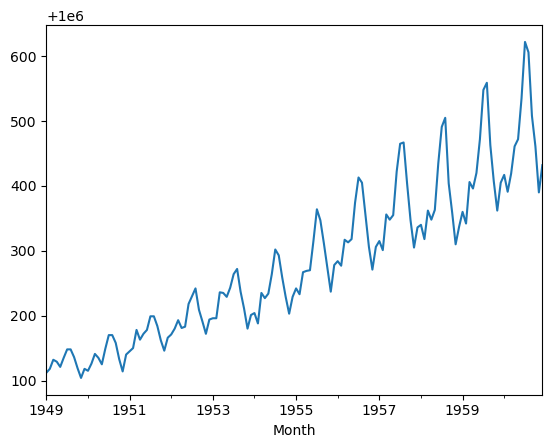

In [52]:
y.plot();

In [ ]:
#nice!!! so easy! and we can do this/perfect application cuz this IS timeseries!!!
#ALHAMDULILLAH HOW NICELY MAKING THE DATETIME AS THE INDEX WORKS W/ AUTOMATICALLY SETTING THE X-AXIS HOW WE WANT!!!

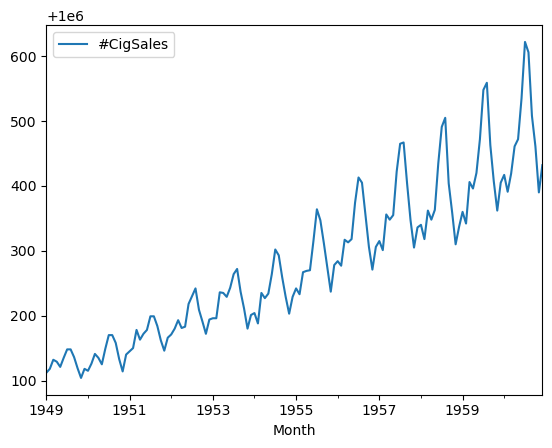

In [55]:
#so really since cigData is JUST this one column y anyway, it's basically the same as just plotting cigData isn't it??

#but they're tryna say - and i think we learned this from experience too, it is nice when you can keep things, esp
#if they're only one column anyway, as a list or series!
#as much as we love the visuals of df's, they can be 'clunky' to work with, or other times much better, like if needa edit, present, view etc

#notice too that a Series is like a cross between a list, or numpy array, and a df, cuz
#IT HAS AN INDEX!!!!
#in fact, notice how the indexing is the same as its DATAFRAME ROOTS/ORIGIN!!!
#maybe you NEED it to start out as a df so that you can format it & index it how you want THEN
#like convert it to a series from there?!
################################################################################################################

cigData.plot();

In [ ]:
#YEP!!!!! ALHAMDULILLAH!!! EXACTLY THE SAME!!!!

In [ ]:
#BTW! you see the CYCLICAL nature!!! wouldn't have expected / thought of that! much more pronounced in latter years
#is it cuz cigarettes are SEASONAL or smth?!?!?!?!?!? like ppl do it more in the SUMMER cuz can be OUTDOORS MORE EASILY AND FOR LONGER!!!!
#never thought of that! so i wonder if ppl who are really into smoking prefer to live in like south cuz easier? at least for winter
#or that if smoking is MORE POPULAR PER CAPITA IN SOUTH, and if it is, if it's driven by weather, or maybe lack of education
############################################################

<AxesSubplot:xlabel='Month'>

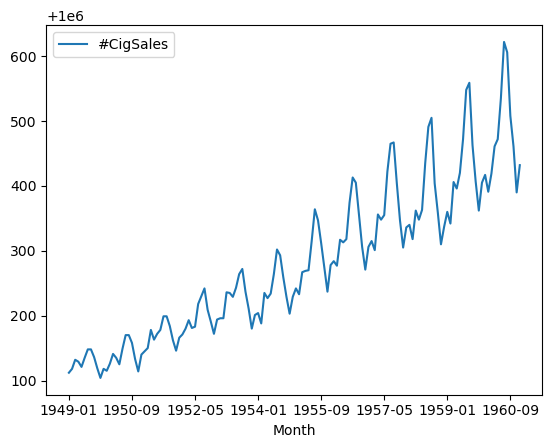

In [56]:
#let's see what woulda happened if we used the CUSTOM format!!

#so all we gotta do is take the original and simply DIRECTLY SET IT TO THE INDEX WITHOUT REFORMATTING EITHER BEFORE OR AFTER!

cigData_backup1_copy2 = cigData_backup1.copy()

cigData_backup1_copy2 = cigData_backup1_copy2.set_index('Month')
#btw, remem the nice thing w/ set_index is it 'shoves'/pushes the column you wanna make index INTO / as the index!
#you don't needa DELETE it/drop it after!!! 2-in-1!!!

cigData_backup1_copy2.plot();


In [ ]:
#AHHHH OKAY THERE YOU HAVE IT! so aH yeah our intuition and/about their guidance was right - you DO wanna have the official datetime format
#so that it'll optimize the plotter engine at least and i'm sure &more importantly the MODELING/PREDICTING ETC!
#so put up w/ the ugly table data lol no one looks at it anyway! that's under hood/behind the scenes! #indahood
#but again, may also be way to format it to liking while still following official datetime format
####################################################################################################

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

Based on the looks, clearly this is Multiplicative. The magnitude of the seasonality aka the amplitude of the swings is clearly going up in proportion to the overall sales.

In [59]:
#ejikkly!
#good idea, let's see/compare MONTHS to see when these seasonal flucts are! see if matches SUMMER theory!!

#ideas:
#can plot each point like a SCATT, and color coordinate by month? oh, but would have to add a column for month
#but prob ANY of these ideas would require adding a column for month
#MAN! WISH IT LET YOU *HOVER OVER*!!!

#OH! well, actually, if you look at my MAL-(wrong/bad)formatted plot, that includes the month, and so from a rough look there,
#you can see those humps seem to line up w/ -09 aka SEPTEMBER, and if you look more closely, that goes to just RIGHT of hump,
#so the HUMP *MUST BE JULY/AUGUST*!!!!!! PRIME SUMMERTIME!

#AND IF YOU LOOK CLOSELY, YOU'LL SEE THAT IT'S NOT JUST A *SINGLE* POINT HUMP, BUT THERE'S ACTUALLY USUALLY *TWO* PEAKS CLOSE TO EACH OTHER
#FOR CONSECUTIVE MONTHS, sometimes one higher, sometimes other, so basically, there's a BIG SHOT UP FROM JUNE TO JULY, THEN JULY & AUGUST ARE
#ABOUT THE SAME TYPICALLY, THEN SHOOTS WAY BACK DOWN IN SEPTEMBER!

#could check out like over time, how has the yearly pattern changed, like how much has the June-jump vs. September-drop been!/changed!

#and would be good if we had like WEEKLY sales, to see like gradual uptick / get better sense of June rise going into July, to see that
#more continuous transition, and same for August back down into September. like could be that BEGINNING september, like thru Labor Day,
#is same or even higher than August days, but then SEVERE drop after that, making it OVERALL seem very low; same w/ END OF JUNE!

#but for the fair weather theory, doesn't seem to line up then that June would be THAT low compared to july august!?

#and as far as the LOWS, that does seem to be the cold/winter season, as expected, but moreso the EARLY winter season/HOLIDAY season, which is
#understandable - family time, higher spirits, less work/stress, and maybe NEW YEARS RESOLUTIONS?! seems like NOVEMBER
#is lowest, Nov-January

##>>>turns out later they ALSO propose / posit that it could be cuz of weather!!! their first theory too! but
#no hard findings / things presented here. they say how if we had OTHER features we could get a better idea
#but yeah that's a good start! but yeah, weather alone doesn't seem to explain it cuz of June so low?

#let's look at an example year
#the LAST year on file, since earlier years aren't as defined
cigData[-13:]
#cigData[:-13] >> aka putting number AFTER colon is the same as doing just [:13], aka FIRST 12! lol aka THE MINUS SIGN DOESN'T DO ANYTHING!
#but somehow also surprisingly doesn't interfere/error either!

#CigSales
Month                
1959-12-01    1000405
1960-01-01    1000417
1960-02-01    1000391
1960-03-01    1000419
1960-04-01    1000461
1960-05-01    1000472
1960-06-01    1000535
1960-07-01    1000622
1960-08-01    1000606
1960-09-01    1000508
1960-10-01    1000461
1960-11-01    1000390
1960-12-01    1000432

<AxesSubplot:xlabel='Month'>

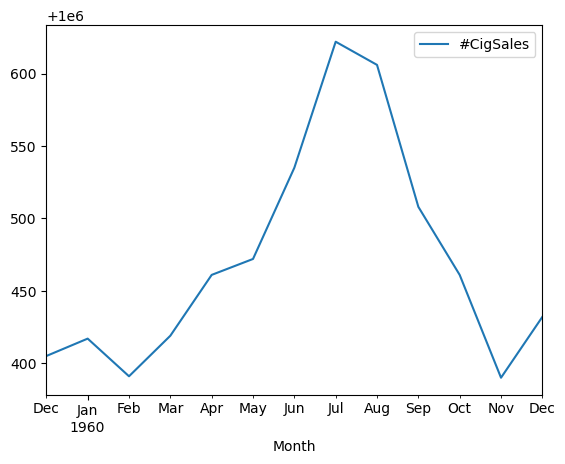

In [62]:
#yep, we see july august are highest! sA. could make this easier to view by plotting JUST THIS year, or by adding a column
#that subtracts 1Million lol like plot does automatically!

cigData[-13:].plot();

In [ ]:
#okay and lows in Nov&/thru/Feb!
#AND THEN ANOTHER IDEA IS YOU COULD PLOT *EACH YEAR* LIKE THIS *SUPERIMPOSED*!!!!
#and like color it w/ SHADING/intensity so that you could see if it's true that every year RISES,
#like overall, you see the hombre gradient looking natural, getting darker as you go up, meaning the
#LATER years, literal HIGHER numbers (ie 1960 > 1949, numerically!)!!!!!!
############################################################

In [ ]:
#OHHHHHHHHHHH! wait a minute - yeah totally forgot - this graph is misleading cuz makes it look like a BIG jump over this time frame,
#but really, THESE ARE ALL LIKE ALMOST *EXACTLY* THE SAME CONSIDERING THAT THE SCALE IS *OVER ONE MILLION*!!!!! if you look close, the y-axis
#basically CUTS OUT the 1MILLION and is JUST showing us the amount BEYOND that, which is on scale of hundreds!

#that's actually pretty crazy if you think about it - that it's that high, yet only fluctuates a few hundred over the years SO CONSISTENTLY!

#for this kinda cylical stuff - gotta compare like EACH MONTH'S PLOT OVER THE YEARS TO SEE IF ACTUALLY GOING UP YEAR-OVER-YEAR!!!!
############################################################

In [ ]:
#So don't know if the whole 'linear' vs. 'exponential/curve' things holds up cuz in the example they give us, the TRENDline is ~linear??
################################################################################################

In [65]:
cigData_backup1

Month  #CigSales
0    1949-01    1000112
1    1949-02    1000118
2    1949-03    1000132
3    1949-04    1000129
4    1949-05    1000121
..       ...        ...
139  1960-08    1000606
140  1960-09    1000508
141  1960-10    1000461
142  1960-11    1000390
143  1960-12    1000432

[144 rows x 2 columns]

In [67]:
cigData_backup1_copy3 = cigData_backup1.copy()

#danggg, it's too late to work w/ the index now! now gotta go back n bring the old column back! or work w/ the older dataset that had it!
cigData_backup1_copy3['Month'] = pd.to_datetime(cigData_backup1_copy3['Month'])
cigData_backup1_copy3['year'] = cigData_backup1_copy3['Month'].dt.strftime('%Y')

cigData_backup1_copy3

Month  #CigSales  year
0   1949-01-01    1000112  1949
1   1949-02-01    1000118  1949
2   1949-03-01    1000132  1949
3   1949-04-01    1000129  1949
4   1949-05-01    1000121  1949
..         ...        ...   ...
139 1960-08-01    1000606  1960
140 1960-09-01    1000508  1960
141 1960-10-01    1000461  1960
142 1960-11-01    1000390  1960
143 1960-12-01    1000432  1960

[144 rows x 3 columns]

In [73]:
cigData_backup1_copy3.year.unique()

array(['1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956',
       '1957', '1958', '1959', '1960'], dtype=object)

In [75]:
years

array(['1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956',
       '1957', '1958', '1959', '1960'], dtype=object)

In [79]:
for i in years:
    print(i)

1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960


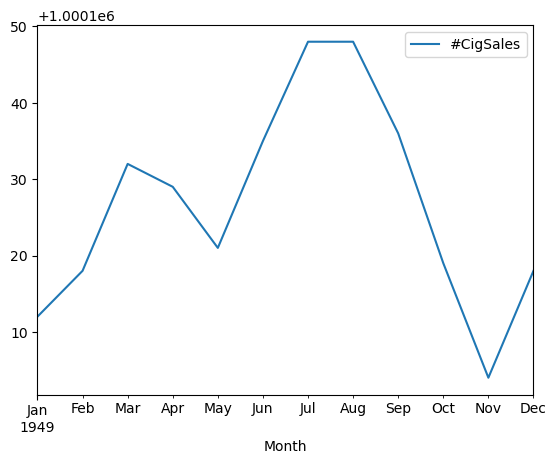

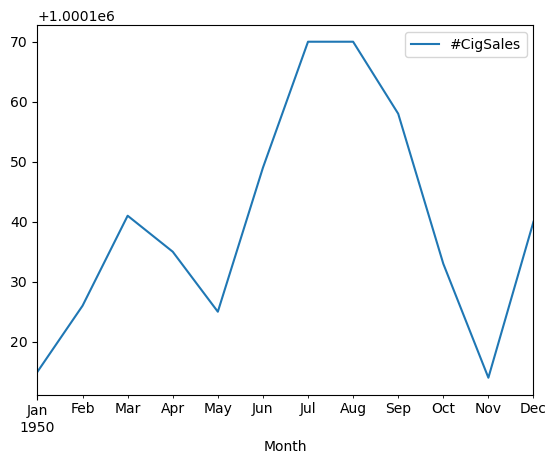

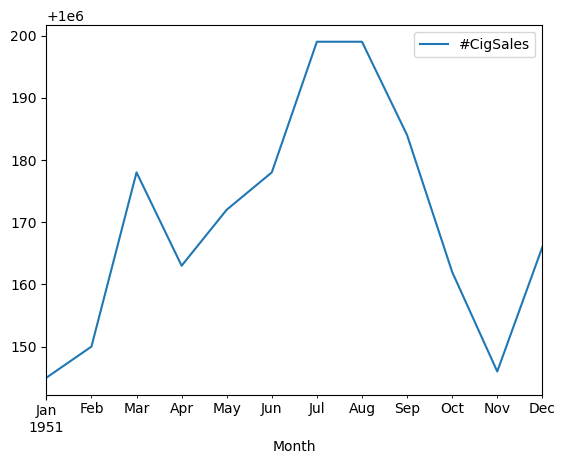

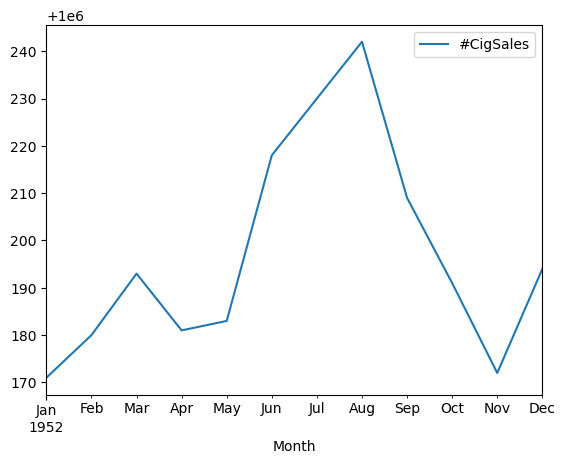

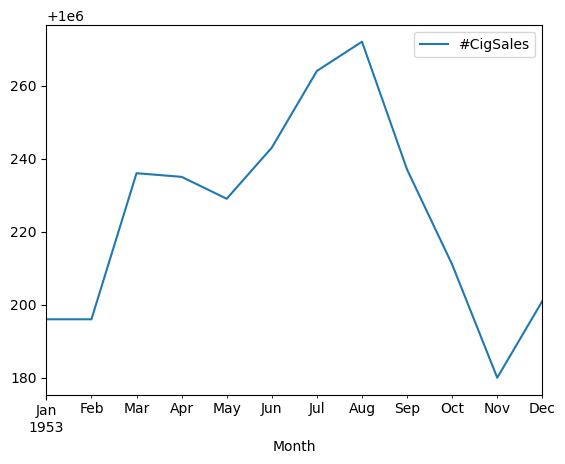

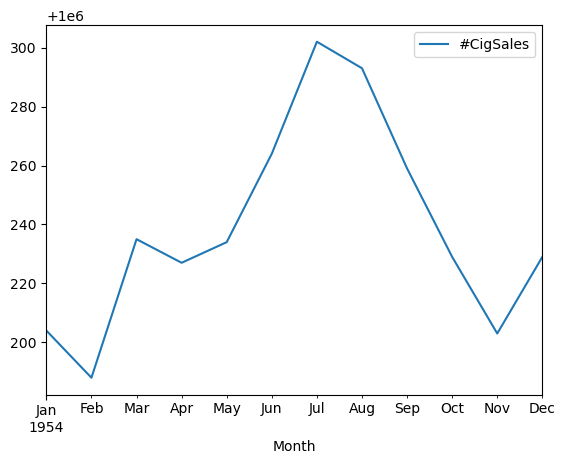

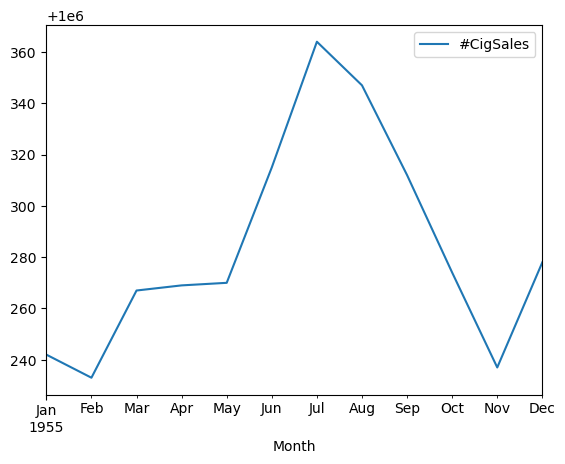

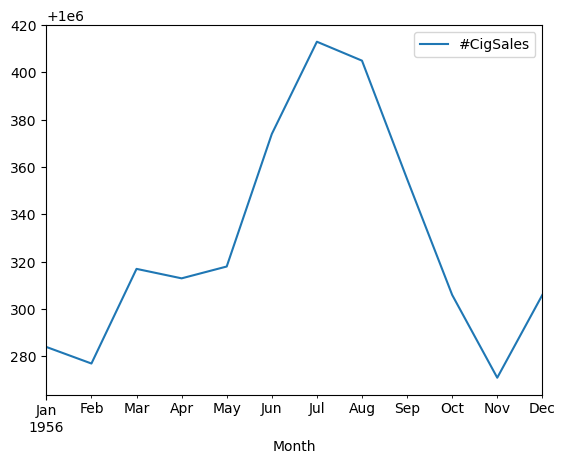

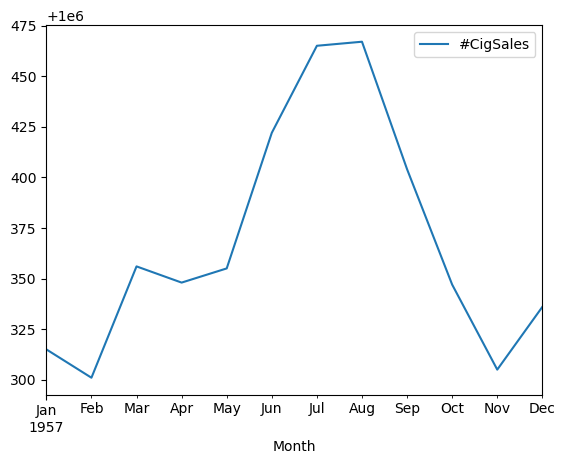

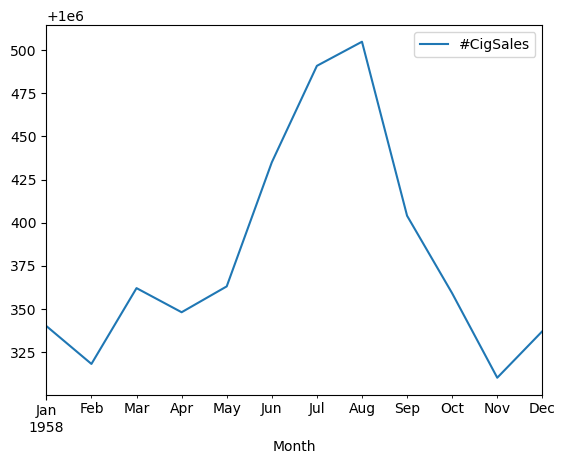

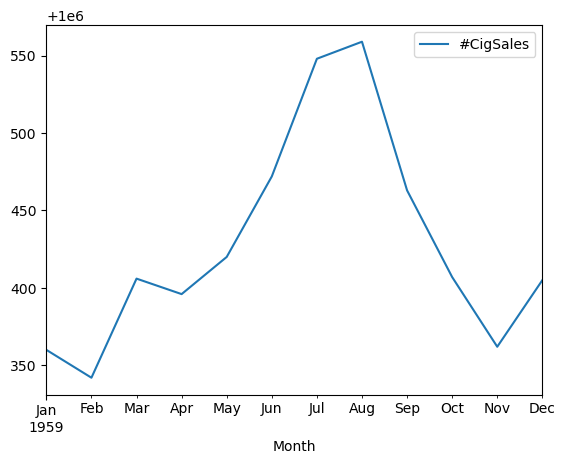

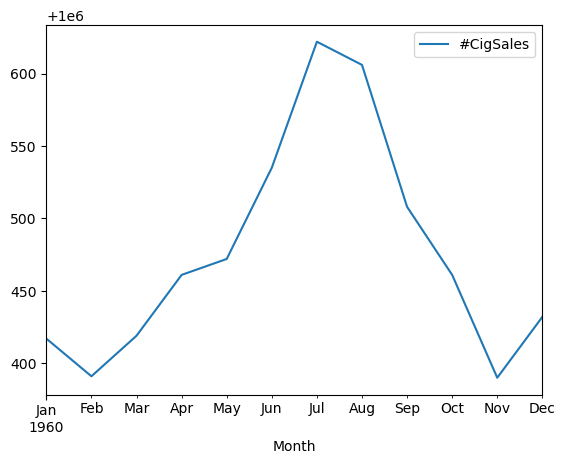

In [86]:
years = cigData_backup1_copy3.year.unique()

import matplotlib.pyplot as plt

for i in years:
    # cigData_backup1_copy3.query('year == "i"').plot(x='Month',y='#CigSales') #no work?
    cigData_backup1_copy3[cigData_backup1_copy3['year'] == i].plot(x='Month',y='#CigSales');

In [ ]:
#okay so we just need this SUPERIMP'D! think you can play w/ toggling LC/FL, or plt.show(), etc
#have to check long section in notes!

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


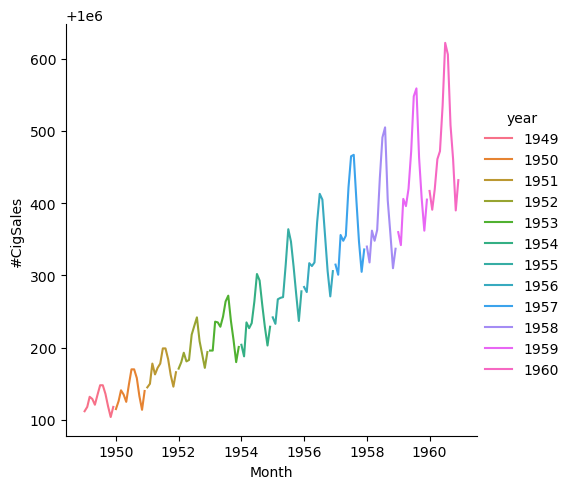

In [87]:
import seaborn as sns
sns.relplot(data=cigData_backup1_copy3, x='Month',y='#CigSales',hue='year',kind='line');

In [89]:
#ohhh, shoot lol, that's cuz 'Month' actually has the YEAR lol, so it's SEQUENTIAL
#so i need to add ANOTHER column for MONTH lol, not to be confused!
cigData_backup1_copy3['month'] = cigData_backup1_copy3['Month'].dt.strftime('%m')


In [90]:
cigData_backup1_copy3

Month  #CigSales  year month
0   1949-01-01    1000112  1949    01
1   1949-02-01    1000118  1949    02
2   1949-03-01    1000132  1949    03
3   1949-04-01    1000129  1949    04
4   1949-05-01    1000121  1949    05
..         ...        ...   ...   ...
139 1960-08-01    1000606  1960    08
140 1960-09-01    1000508  1960    09
141 1960-10-01    1000461  1960    10
142 1960-11-01    1000390  1960    11
143 1960-12-01    1000432  1960    12

[144 rows x 4 columns]

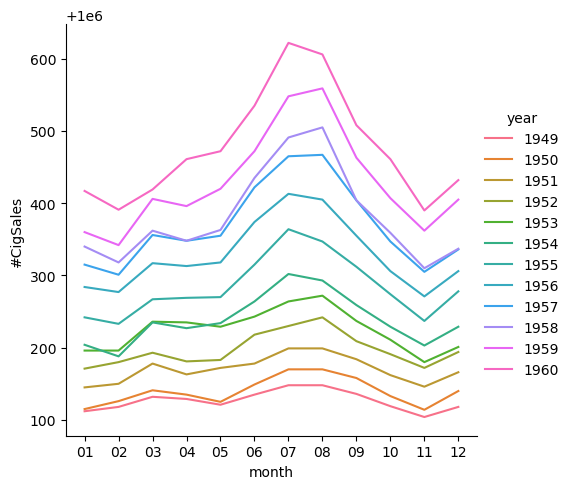

In [91]:
#now let's try
sns.relplot(data=cigData_backup1_copy3, x='month',y='#CigSales',hue='year',kind='line');


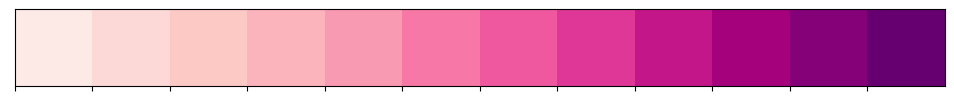

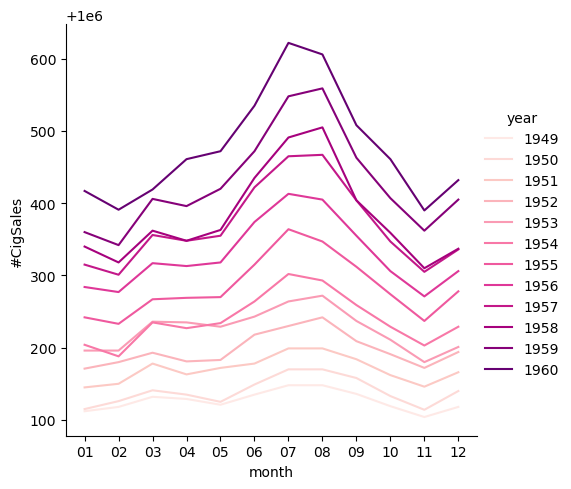

In [102]:
#ALHAMDULILLAH!!!! thing is, you can't actually be CERTAIN right off the bat that each one going up is THE NEXT YEAR,
#to prove our theory that it's going up each time, but YOU DO SEE THE GROWING AMPLITUDE / SEASONAL SWING EACH YEAR!!!
#we'd wanna do a INTENSITY palette, and then reverse order of legend!

# sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, as_cmap=True)
# sns.color_palette("Blues", as_cmap=True)
sequential_colors = sns.color_palette("RdPu", 12)
sns.palplot(sequential_colors)

sns.relplot(data=cigData_backup1_copy3, x='month',y='#CigSales',hue='year',kind='line',palette=sequential_colors);




In [110]:
#########################
#REVERSE THE ORDER OF A LIST!!!!!
years[::-1]

array(['1960', '1959', '1958', '1957', '1956', '1955', '1954', '1953',
       '1952', '1951', '1950', '1949'], dtype=object)

In [ ]:
#DROOOOOPE!!!!!
#ALHAMDULILLAH!!!!!
#######################################################

In [130]:
# years_rev = years[::-1]
years_rev = years[::-1].astype('int') #does this make diff?
years_rev

array([1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950,
       1949])

TypeError: legend only accepts two non-keyword arguments

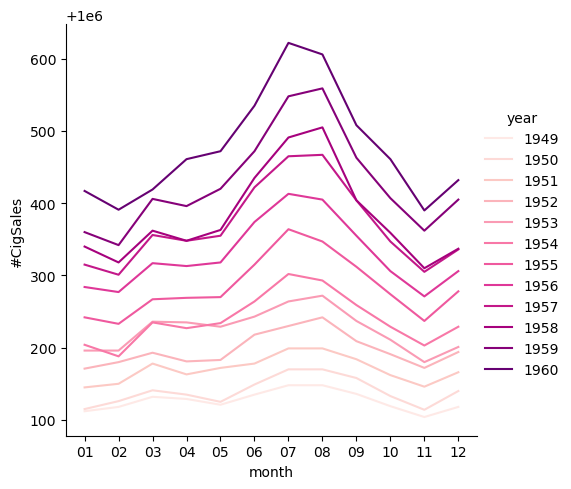

In [136]:
#ALHAMDULILLAHI RABBIL 'AALAMEEN!
#and now if we can just get the legend ordering fixed

sns.relplot(data=cigData_backup1_copy3, x='month',y='#CigSales',hue='year',kind='line',palette=sequential_colors);

# plt.legend('1960', '1959', '1958', '1957', '1956', '1955', '1954', '1953', '1952', '1951', '1950', '1949')

#THIS CODEBLOCK IS SUPPOSED TO WORK FOR REORDERING LABELS IN GENERAL, BUT I GUESS DOESN'T WORK W/
#THIS SPECIFIC KINDA CASE CUZ of maybe numbers as text cuz pulled from datetime objects thing!

# reordering the labels
# handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
# labels = ['1960', '1959', '1958', '1957', '1956', '1955', '1954', '1953', '1952', '1951', '1950', '1949'] #otherwise doesn't work as STRING, which is what it is! since i extracted datetime object!
# order = list(years_rev)

# pass handle & labels lists along with order as below
# plt.legend([handles[i] for i in order], [labels[i] for i in order])

#this handles, labels thing is supposed to work but maybe doesn't for me since datetime

In [ ]:
#mannnn. really hate when i can't get SIMPLE stuff!!!! like simply changing order of legend!


In [2]:
#labels

In [128]:
# handles

In [129]:
# order

[1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949]

In [3]:
# [handles[i] for i in order]

In [121]:
list(years_rev)

[1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949]

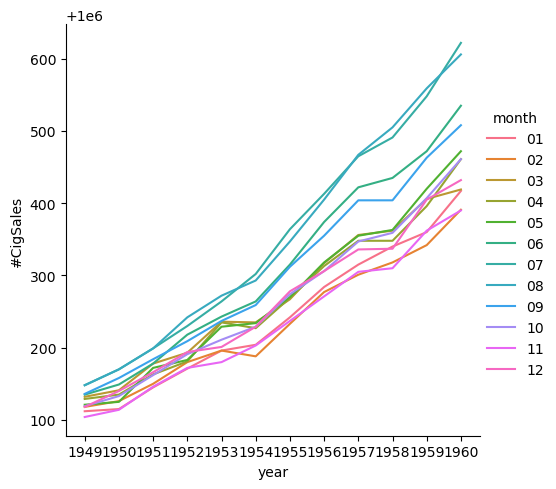

In [137]:
#now do the OTHER plot! EACH MONTH, over the years!
sns.relplot(data=cigData_backup1_copy3, x='year',y='#CigSales',hue='month',kind='line');


In [ ]:
#ALHAMDULILLAH!!!! that's hard to say, like it does seem relatively 'straight'ish/stick-ish, like a line, but could also see as getting SHARPER/
#STEEPER later on, but it could be that that's only for the SEASONAL SPIKES aka SUMMERTIME!!!
#*remem*, here, unlike last, it's not 'sequential'/chronological going up as in it's not like January bottom (01) and December (12) top!!!
#it's obv in order of whatever's highest!
#it's going up in value LEFT-TO-RIGHT cuz THAT'S over the years here! whereas in last, years were represented down to up!
#but it does seem that months' ranking was relatively consistent thru the years! maybe switched ONE place up or down! but nothing drastic!
################################################################################################################

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [ ]:
#so the rate of increase is increasing?? is that a condition to be multiplicative? and that means exponential
#doesn't it?? that's a little hard to tell tho here from the raw output - like you have to imagine a single
#trendline first of all which is hard thru the seasons - but you could see maybe a slight curve upwards,
#but the straight line wouldn't be very far off from that
#and that's pretty much the story the above graph shows - maybe just a slight curve,
#so if a curve is supposed to show that it's multiplicative vs./over a simple STRAIGHT line,
#then it's very subtle here, not obvious, even though you'd *THINK* it'd be based off
#the VERY CLEARLY wildly growing/escalating AMPLITUDE!!! so yeah, let's stick to using THAT as the basis
#to determine Add vs. Mult!

#so remem additive will still be increasing IN GENERAL, but just like gradually/linearly?
#but the confusing thing is this dude's example made it seem like GENERAL trend for MULTIPLICATIVE was
# ALSO increasing LINEARLY!
#so like is it matter/difference of like whether linear increase is "GRADUALLY" or not??
#but then how do you define that/what's cutoff??
########################################################################################################################

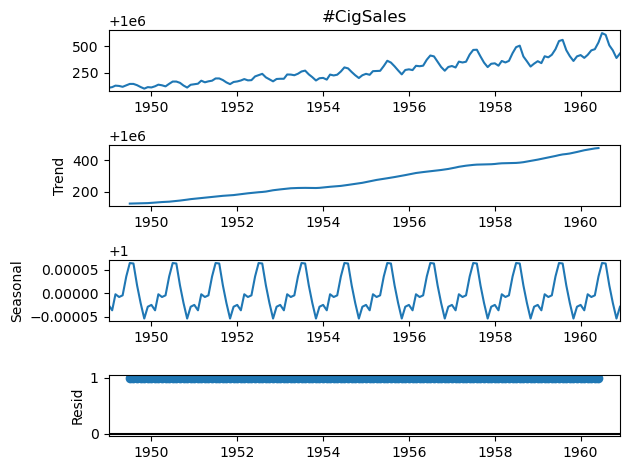

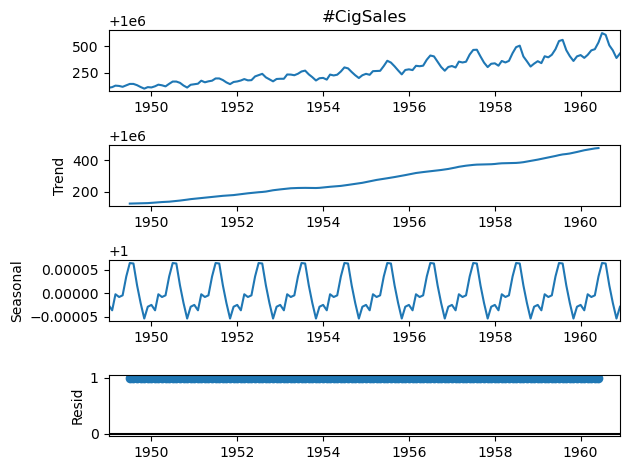

In [139]:
import statsmodels.api as sm

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot();

In [ ]:
#whoa weird! it plots TWICE just cuz/if you don't put the SEMICOLON SUPPRESSION! THAT'S A NEW ONE!!

In [ ]:
#wow look how pronounced those SEASONALITY SWINGS BECOME!
#ahhh, okay - so that TREND line i guess is like the moving average? or basically the BEST FIT??
#but again - that's *LINEAR*??
#also, we could add the trendline to the timeseries! that'd be good
#WHOAAA WHY/HOW IS 'SEASONAL' LIKE *PERFECTLY* CONSISTENT AND *EXACTLY* THE SAME THROUGHOUT?!?
#AND WHY IS RESIDUAL PERFECTLY SITTING AT 1?? related to perfect seasonal??
##################################################################################################


### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [ ]:
#WHATTHA HIGGY SIGGY?! we didn't even cover that in class!

In [142]:
#"As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time.
#A stationary time-series dataset will have constant mean, variance, and covariance" (aka/thus constant standard deviation too)"

from statsmodels.tsa.stattools import kpss
#lol wow, they offer no instruction on how to use it

sm.tsa.stattools.kpss(cigData)#, regression='ct') >> left to default 'c'!

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.651312235417082,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [ ]:
#oh dzead, think we can just simply do:
# kpss(cigData)
#or, ofc
kpss(y)#!
#or
# kpss(y_log)

In [ ]:
#umm why we getting this warning?
#hushed now lol

In [144]:
#compare to 'ct'
sm.tsa.stattools.kpss(cigData, regression='ct')

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.09614984852336865,
 0.1,
 4,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [ ]:
#so the pvalue changes depending on the REGRESSION arg used aka which of the two NULL hypotheses!
#'c' (default) is that the data is stationary around a CONSTANT
#'ct'          is that the data is stationary around a *TREND*!
#...BUT WHAT DOES THAT MEAN?!?!
#like i kinda thought it WOULD BE the latter, cuz like it's a constantTREND going up!
#whereas 'c' constant...value/mean i guess makes it seem like it's not doing anything, not changing over time...
# 
# so, if null is that it's stationary, that means that mean/other metrics AREN'T changing over time...
#oh... okay, so then yeah, i guess that WOULD BE 'c'!!!
#but then when would the null be 'ct', stationary around a constantTREND cuz then isn't it NOT STATIONARY if there's a constant trend in one direction??
#######################################################################################################################################

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

In [ ]:
#yep! so as suspected, this data's def not stationary so we can REJECT the null hypo that it is!
#but we still gotta MAKE the data stationary!

### 3c. Making the data stationary 
Let's recall what it looks like. 

In [ ]:
#we do that by DOING FIRST DIFFERENCES RIGHT?!

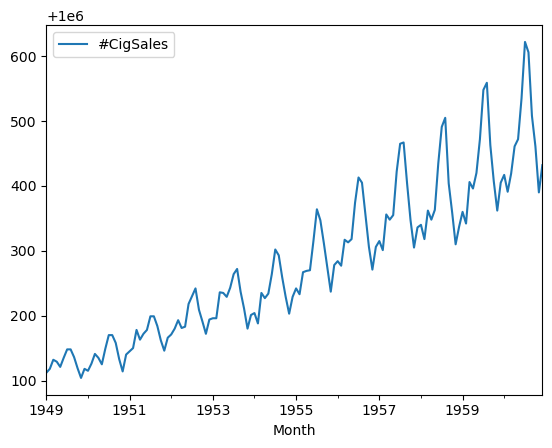

In [146]:
y.plot();

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [ ]:
#"covariance seems constant" ... - how do you mean? like the fact of its CONSISTENCY in the seasonality?
#like which months are high & which are low? like months prob have strong correlations to each other!
################################################################################################

#TAKE NATURAL LOGS OF ALL THE VALUES?!?! DID WE EVER EVEN COVER THAT?!?
################################################################################################

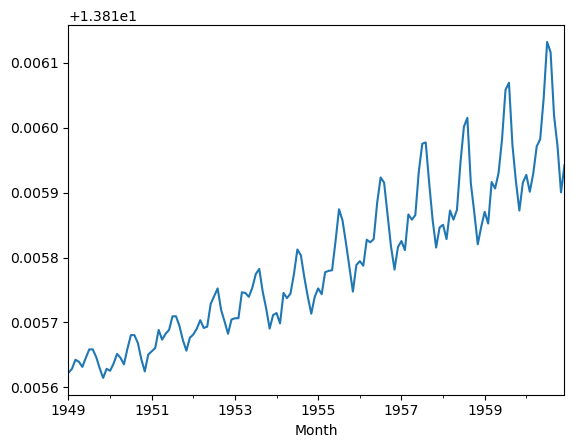

In [157]:
import math
# math.log(cigData['#CigSales']) #nope
import numpy as np
np.log(y).plot();

In [ ]:
#umm, that looks exactly the same... like proportions are same, just scaled the values down...
########################################################################################################################


When you plot this, you can see how the variance in our data now remains contant over time.

In [ ]:
#where are you seeing that? looks exactly same...

<AxesSubplot:xlabel='Month'>

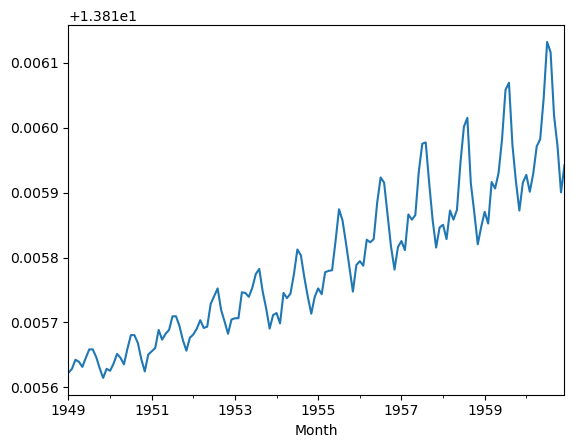

In [490]:
#lol just in case any funny business w/ like 'np.log(y).plot()'
y_log.plot();

In [ ]:
#LOOKS EXACTLY THE SAME!!! NOTHING CHANGED! SAME SHAPE JUST DIFF *SCALE*!!!

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [159]:
#okay this is what i was talking about / what we've seen. like yeah this'll give a constant mean,
#make it STATIONARY, aka be WHITE NOISE, constant line thru middle

monthly_diffs = y.diff()
monthly_diffs

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
              ... 
1960-08-01   -16.0
1960-09-01   -98.0
1960-10-01   -47.0
1960-11-01   -71.0
1960-12-01    42.0
Name: #CigSales, Length: 144, dtype: float64

In [ ]:
#yep @ the one less/NaN first! know that/offset/shift

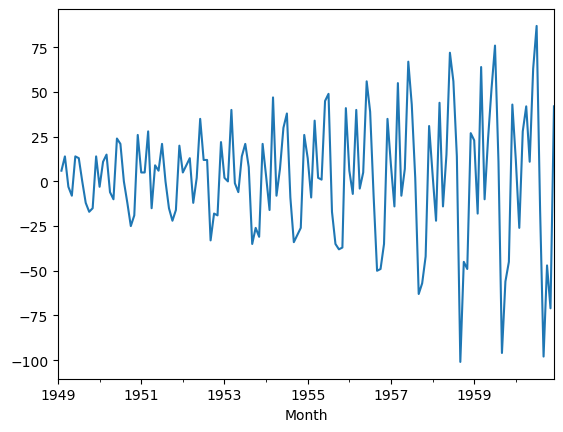

In [161]:
#let's plot the diffs
monthly_diffs.plot();

In [162]:
#very nice!

#oh, just realized, i didn't do this w/ the LOGGED values! let's see if that makes diff

monthly_diffs_log = np.log(y).diff()
monthly_diffs_log

Month
1949-01-01         NaN
1949-02-01    0.000006
1949-03-01    0.000014
1949-04-01   -0.000003
1949-05-01   -0.000008
                ...   
1960-08-01   -0.000016
1960-09-01   -0.000098
1960-10-01   -0.000047
1960-11-01   -0.000071
1960-12-01    0.000042
Name: #CigSales, Length: 144, dtype: float64

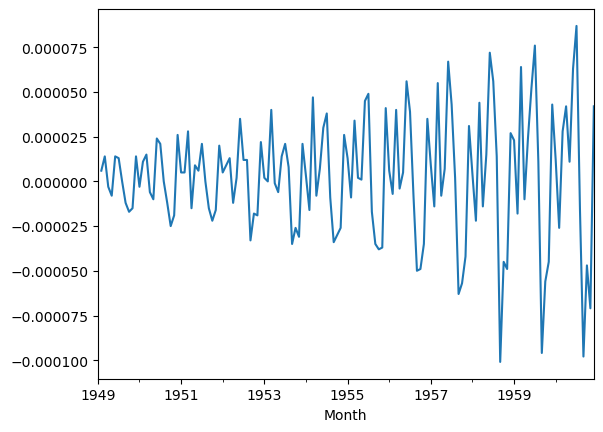

In [163]:
monthly_diffs_log.plot();

In [ ]:
#nope, again aH looks exactly the same
#so, confused about what log transforming did here?
#i know we've seen how it transforms other plots, like ones that are skewed
#but here these vals are so close to begin w/ maybe that's why?
##############################################################################

In [164]:
#ubb have we done pvals in this context?
#let's check pvals for both non-log & log

#original (like many things, can use either cigData or y - same thing)
# sm.tsa.stattools.kpss(y)
kpss(y)
#kpss(y_log)

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.651312235417082,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [165]:
#non-logged diffs

# sm.tsa.stattools.kpss(monthly_diffs)
kpss(monthly_diffs)

ValueError: cannot convert float NaN to integer

In [167]:
#oh yeah lol gotta drop first!

#NON-logged diffs
# sm.tsa.stattools.kpss(monthly_diffs.dropna())
kpss(monthly_diffs.dropna())

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.023897614400183963,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [168]:
#logged diffs
# sm.tsa.stattools.kpss(monthly_diffs_log.dropna())
kpss(monthly_diffs_log.dropna())

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.023897674207570555,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [ ]:
#yeah log/non-logged BASICALLY EXACTLY THE SAME!

#so yeah, now our p-val - of our diffs/white noise - is > .05, meaning we'll say this *IS* indeed stationary,
#like we were hoping for!/expected

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [ ]:
##########
#"Recall that ARIMA models are based around the idea that it's possible to predict the next value in a
#time series by using information about the most recent data points. It also assumes there will be some
#randomness in our data that can't ever be predicted."
##########

In [172]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
# from statsmodels.tsa.arima_model import ARIMA #>>THERE WAS AN ERROR/WARNING FROM THIS ONE, DEPRECATED SO IT SAID TO USE:
from statsmodels.tsa.arima.model import ARIMA


#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [ ]:
#initial questions
#make a diff if used logged or not?
#how do we know what to set for the params?
#and are we doing AR or MA? or combined?

#NOTE, that in this stage we're not predicting the missings from 1961-01 TO 1969-12 but rather gonna FIRST DO
#A *TRAIN/TEST SPLIT*!!!!!! then *WINNER GOES ON!*
#but ALSO NOTE! even then, since obvy those DATETIMES are MISSING, we OBV WON'T BE ABLE TO GET SCORE / ACCURACY
#ON THOSE!!! so makes sense why we wouldn't be using those now, cuz THIS IS FOR *SCORE/ACCURACY*!!!!!!
#and then we'll pick the best performer on the unseen/masked that we DO have answers for to grade/check against,
#and we'll trust that that one will do the best job of predicting the TRUE UNKNOWN!!! so out of all the options,
#we'll be best off trusting THAT ONE!!!!!

#so we're NOT just FITTING the full data w/ a best fit trend line, though we could
#what we'll do is:
    #1. get model w/ hyps/params that is best performer in test on train/test split, trained on train
    #2. use that combo of params to fit the FULL SET of ACTUAL data, aka train+test
    #3. FORECAST out ahead from/using that

#and again, we DON'T have any X explanatories! not even the datetime! that's only the INDEX! that's used for
#PLOTTING aka is just the *X-AXIS* TICK MARKERS/LABELS!!!!

In [ ]:
#note that we don't just do a simple .PREDICT() on the trained model that's fit on training like we do in other things
#here, we're gonna have to do a complicated STEP-WISE prediction, predicting only ONE/THE NEXT/ONE-AHEAD point at
#a time!!!
#if we try running .predict() on the training or full set, it'll simply do a BEST FIT!!! aka *BACK-predict*!
#you wouldn't even need to put in an X explanatory in the .predict()!

In [ ]:
#ohh so maybe we gotta use PLOT_PREDICT?! even though didn't mention...
    #>>TURNS OUT CRAZILY THEY *NEVER DO*!!! but i do it again on my own!
    #but remem, that requires us to specify the pdq and so again, this stage is to first
    #FIGURE OUT WHAT THE OPTIMAL PDQ ARE! SO LET'S GO! start w/ that!


In [ ]:
#ohhh wait! so since this is SEASONAL we'd wanna do gaps/LAGS of like *12* RIGHT?!
#OH WAIT! but that's not what's in *ORDER*, that's the number of lag TERMS!!!
#so how do we set the lag to what we want? we def did that in the beginning
#yeah like, if we looked at the autocorrelation, we'd find it high for EVERY 12 PERIODS!!!
####################################################################################

#so we won't look at that right now, and we'll be playing w/ tweaking the pdq params next i guess...like maybe w/ GRIDSEARCH!

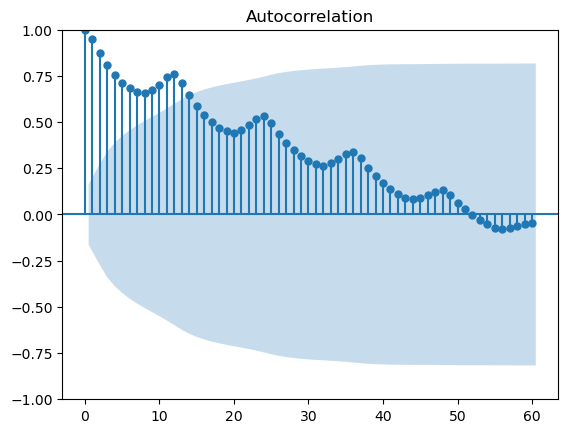

In [34]:
#we SHOULD check the autocorrelation tho for/@ multiples of 12 tho - BUT AGAIN CRAZILY THEY NEVER HAVE US
#LOOK AT THAT!!!!!
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y,lags=60);

In [ ]:
#WHOAAAAAA! THAT'S INTERESTING!!! DON'T KNOW IF I EVER SAW ONE LIKE THAT BEFORE!
#like a bridge wire gates!!! rolly coaster! CURVED! swooping!
#but also interesting - so like, first of all, for multiples of 12, the ONLY one that's beyond SIGNIFICANCE is the
#VERY *FIRST* ONE!!! why's bar so high?!
#But moreover.... WHY ARE THE *FIRST FEW* HIGHER AUTOCORRELATION THAN EVERYTHING ELSE?!!??!!? THE MOST!!
#like yeah it dips and goes back up @ 12 months, but months/lags 1,2,3,4 are all HIGHER!!!!
#so this isn't the thing like where ONLY LAG1 will be significant!?
#it seems very like predictable/steady/methodical/systematic! melodious! harmonic/a!!!/harp!
#have anything to do w/ like how maybe months NEXT to each other could have more to do w/ the same month
#in PRIOR year cuz of OVERALL RISING TREND?? but like WILL have more in common w/ 12 months ago/same month last year
#then OPPOSITE time of year month, like SIX months ago in SAME year?!?!
#that's what i'm thinking. it's like this follows 'inverse' pattern of its GENERAL TREND!!!!!
#oh, and doesn't switch to negative till VERY END! but also/still retains HUMP/WAVE behavior!
##################################################################################################


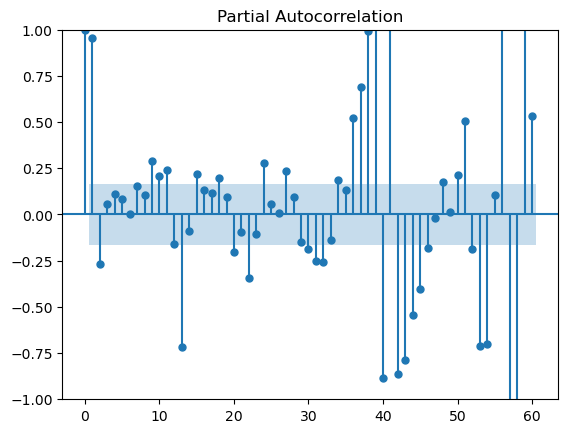

In [36]:
#maybe let's try like the other/partial? see if any diff?

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y,lags=60);

In [ ]:
#whoaaaaa! TOTALLY DIFFERENT! alot more alternation. many are OFF CHARTS! 12 is def high... 24 actually not so much?
#36 starts the shootup, BUT THEN 37 THRU 42 ARE CRAZY HIGH, IN FACT 39 & 41 AND SOME OTHERS LIKE 57/58 ARE
#*LITERALLY* OFF THE CHARTS!!!!!! THROUGH THE ROOF/FLOOR!!!!!
#gotta go back and look how to interpret these but don't think it's the same as like seasonal lags w/ regular
#autocorrelation...
################################################################################

In [ ]:
#So note i thought we'd GRIDSEARCH to try all the params combos, but it wasn't really compatible cuz
#i guess no Xplanatory variables to put into model?!
#so that's why we hadda do the old fashion nested for loop way!
###############################################################

In [ ]:
#error saying freq (lol freak) not given so used inferred, which was 'MS' is *MONTHS*!!!!! WHICH WAS RIGHT!!!

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


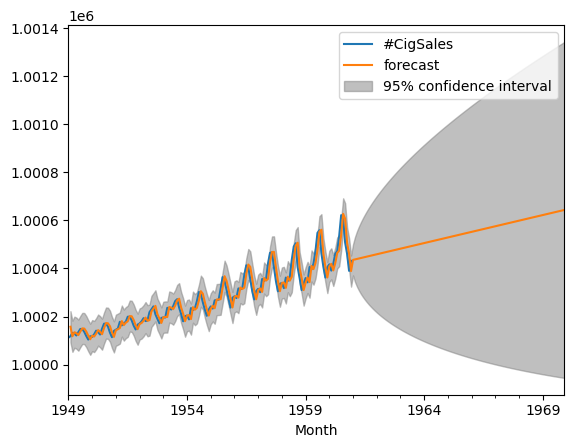

In [192]:
#just an EXAMPLE one. we'll get OPTIMAL pdq params next!

model = ARIMA(y, trend='t', order=(1,1,1)) #ohh, right! we ALREADY did first differences... why though and not 12th?! didn't even look at P/ACF!
#but they did say to do that. so i guess we'll just leave it to GRIDSEARCH to play around?! cuz nothing i'm trying is making sense
#in fact, thing that made MOST sense was using 12's!
result = model.fit()

fig, ax = plt.subplots()
y.plot(ax=ax) #actuals
plot_predict(result, start='1949-02-01', end='1969-12-01', ax=ax)#, freq='M') #predictions
plt.show() #need this or else duplicates for some reason?? maybe cuz subplots?

In [ ]:
#general upward trend!

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/s

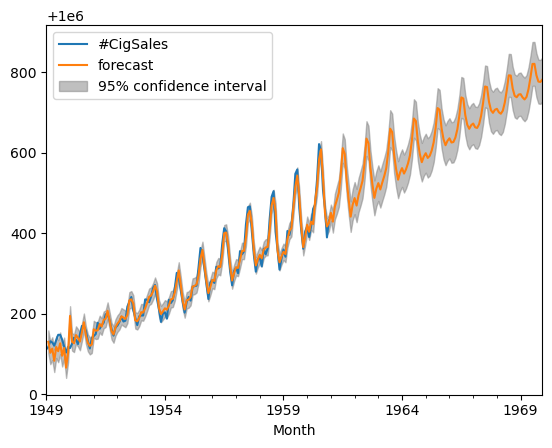

In [196]:
#lol this is mistaking ORDER for LAGS, which didn't even turn out to be that strong AC anyway?
#but this turned out cool tho we'd never be able to get PREDICTIONS like this, don't think, at least not with CONFIDENCE,
#tho this looks very believable cuz continues GENERAL PATTERN & GENERAL TREND UP! rather than straightlining
#it/averaging it like ^this guy!
model = ARIMA(y, trend='t', order=(12,1,12))
#ok doesn't let me do d=12? hmmm, regardless of what other 2 nums are?
result = model.fit()

fig, ax = plt.subplots()
y.plot(ax=ax) #actuals
plot_predict(result, start='1949-02-01', end='1969-12-01', ax=ax)#, freq='M') #predictions
plt.show() #need this or else duplicates for some reason?? maybe cuz subplots?

In [ ]:
#INTERESTING! if this is legit/makes sense, then the amplitude REGRESSES
#and pedals BACK! it's like it reverses its path and goes back to
#way it STARTED!

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


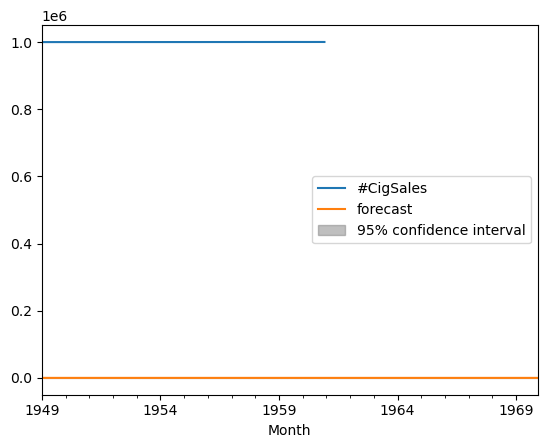

In [202]:
#some of warnings observed lol
#non-invertible, non-stationary, max likelihood, no frequency, etc!

#clearly using 't' for trend which i thought meant 'straight line' DOESN'T mean straight line!!!
##################################################################################

#like are we supposed to use the DIFFS instead of the values themselves??

model = ARIMA(monthly_diffs, order=(1,0,1))
#tried log version too, same
result = model.fit()

fig, ax = plt.subplots()
y.plot(ax=ax) #actuals
plot_predict(result, start='1949-02-01', end='1969-12-01', ax=ax)#, freq='M') #predictions
plt.show() #need this or else duplicates for some reason?? maybe cuz subplots?


#OHHHHHH - this won't really show anything cuz the diffs are SUCH A *SMALL* NUM so VALUES WILL BE COMPLETELY DIFF SCALES
#TO BE ABLE TO PLOT ON SAME AXIS!!!! that's why these just look like flat lines! lol
#################################################################################

In [ ]:
#okay, now back to what THEY're asking for!

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [41]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.

#okay so here we're basically gonna *CROSS-VAL*!!!

In [221]:
#btw here's an example of how to get the mse of best fit w/ an arbitrary choice of pdq/equation/model, just to give you idea

model = ARIMA(y, order=(1,0,1)) #or y_log - that's prob right one/one they want us to go with!
result = model.fit()
y_pred = result.predict()
mean_squared_error(y,y_pred)

1153.1928989862884

In [228]:
#but yeah, back to cross-valing!

#HERE'S SHOWING HOW GRIDSEARCH WON'T WORK!!!

from sklearn.model_selection import GridSearchCV

params = {'p': range(13), 'd': range(13), 'q': range(13)} 

model = ARIMA(y)
#model = ARIMA(y, order=(p,d,q))


gscv = GridSearchCV(model,params)

gscv.fit(cigData.index, y)

# result = model.fit()
# y_pred = result.predict()
# mean_squared_error(y,y_pred)


/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


TypeError: Cannot clone object '<statsmodels.tsa.arima.model.ARIMA object at 0x18d0e9970>' (type <class 'statsmodels.tsa.arima.model.ARIMA'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [42]:
#SO LET'S JUST GOTTA DO MANUAL NESTED FOR-LOOP WAY!

#they only want us to try a couple of choices for each pdq to keep it simple! i was trying 12 at first lol
#but would've taken FOREVER!!!

In [ ]:
#NOTE, i did MANY WRONG WAYS the first time(s) around;
#the FIRST/original wrong way i did things, below, was cuz i didn't do train/test split!
#i also didn't use the LOGGED numbers/version
#this made it much easier, but all this did was get the best fit on the EXISTING DATA!

In [237]:
ps = range(3)
ds = range(3)
qs = range(3)

p_list, d_list, q_list, mse_list = [], [], [], []

results = pd.DataFrame({'p','d','q','mse'})

for p in ps:
    for d in ds:
        for q in qs:
            model = ARIMA(y, order=(p,d,q))
            p_list.append(p), d_list.append(d), q_list.append(q)
            result = model.fit()
            y_pred = result.predict()
            mse = mean_squared_error(y,y_pred)
            mse_list.append(mse)
            
pd.DataFrame({'p':p_list,'d':d_list,'q':q_list,'mse':mse_list}).sort_values('mse').reset_index(drop=True)

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency informa

p  d  q           mse
0   2  0  2  1.115835e+03
1   2  0  1  1.128021e+03
2   1  0  2  1.147723e+03
3   1  0  1  1.153193e+03
4   2  0  0  1.179927e+03
5   1  0  0  1.301635e+03
6   0  0  2  2.275922e+03
7   0  0  1  4.382362e+03
8   0  0  0  1.429197e+04
9   2  1  2  6.946001e+09
10  2  1  1  6.946001e+09
11  1  1  2  6.946001e+09
12  0  1  2  6.946001e+09
13  2  1  0  6.946001e+09
14  0  1  1  6.946001e+09
15  1  1  1  6.946001e+09
16  1  1  0  6.946001e+09
17  0  1  0  6.946001e+09
18  2  2  2  8.685012e+09
19  2  2  1  8.685024e+09
20  1  2  2  8.685024e+09
21  1  2  1  8.685030e+09
22  0  2  2  8.685038e+09
23  2  2  0  8.685040e+09
24  0  2  1  8.685049e+09
25  1  2  0  8.685052e+09
26  0  2  0  8.685198e+09

In [ ]:
#SO WINNER IS 202!!! lol exton highway :P
#101, remem, lol half, is the one i arbitrarily tried and yes, remem it gave me mse of 1,153.193!!! matches here

In [233]:
#CAN'T ASSIGN ONE VALUE TO SEVERAL VARIABLES WHEN YOU WANT ALL TO HAVE THE SAME VALUE!!!
#can't mismatch/gotta match!
p_list, d_list, q_list, mse_list = []

ValueError: not enough values to unpack (expected 4, got 0)

In [ ]:
# Finally, we can find the optimum ARIMA model for our data.
# Note - this can take a while...!
#lol to FIGURE stuff out, or to RUN the code!? ;P
#aH done

In [ ]:
#NOTE WE NEVER DID ANYTHING LIKE THIS IN TRAINING/CLASS FOR TIMESERIES SO I DIDN'T THINK TO USE TRAIN/TEST SPLIT!

###############but they didn't simply use TRAIN/TEST SPLIT CUZ THIS IS *TIME-SERIES* SO THE *ORDER*
#OF THE POINTS *MATTERS* AND THE WHOLE POINT IS WE'RE TRYNA PREDICT THE *FUTURE*!!!!
#so yeah, they made it really confusing, shoulda stuck to the initial story and had us predict on the missing thru 1970 dates,
#...but then i guess the whole thing is that, if they WERE missing, then obv *WE DON'T HAVE TRUTH VALUES*!
#so we'll work w/ what we have, splitting it up, then the MISSING 1970 DATA WILL ACT LIKE THE *FINAL *RESERVE*** SET EXCEPT WE WON'T
#BE ABLE TO *GRADE* IT BUT RATHER JUST TRUST THAT THIS MUST BE THE MOST *ACCURATE* ONE, BASED ON PERFORMANCE IN THE REST OF THE SET!!!!
#and in fact this way makes more sense as a reason for doing the 'hold out' set - WHEN YOU *DON'T* HAVE ANSWERS/TRUTH VALUES!!!!

#so yeah, that's why we're just gonna split *IN ORDER*!!!


#nice thing is you don't really have to worry too much about whether using like just values themselves
#or full Series etc! both work fine so just keep SIMPLEST, do as little addl work as possible! unlike them lol unnecessary


In [ ]:
#and here's an example of the other wrong i kept doing. i kept getting this cuz i totally didn't get
#the one-step at a time, update-training-set every step thing! oh, and ofc i STILL wasn't using logged here lol,
#though i think here it didn't make a diff

In [288]:
#aH!!! at least we chose the right range!

split = int(.8*len(y))
train, test = y[:split], y[split:]

ps = range(3)
ds = range(3)
qs = range(3)

p_list, d_list, q_list, mse_list = [], [], [], []

for p in ps:
    for d in ds:
        for q in qs:
            p_list.append(p), d_list.append(d), q_list.append(q)
            predictions = []
            for t in range(len(test)):
                model = ARIMA(train, order=(p,d,q))
                result = model.fit()
                predictions.append(result.forecast())
            mse_list.append(mean_squared_error(test,predictions))
            
pd.DataFrame({'p':p_list,'d':d_list,'q':q_list,'mse':mse_list}).sort_values('mse').reset_index(drop=True)

/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/deens/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/d

p  d  q           mse
0   0  0  2   6144.148184
1   1  0  0   8207.802532
2   0  1  0   8673.931034
3   1  1  2   8770.117800
4   2  1  1   8788.434119
5   1  0  2   8878.799031
6   2  1  0   8935.032039
7   0  1  1   8939.951784
8   0  1  2   8946.212245
9   1  1  1   8955.802026
10  1  1  0   8956.213159
11  1  0  1   9211.514732
12  2  0  1   9282.365900
13  2  1  2   9363.852707
14  2  0  2   9511.425942
15  2  0  0   9685.342771
16  0  0  1  10529.837000
17  1  2  1  17419.820344
18  0  2  2  17426.851049
19  2  2  0  17434.700460
20  0  2  0  17487.172414
21  0  2  1  17586.463555
22  1  2  0  17596.723228
23  1  2  2  17637.692490
24  2  2  1  17687.173154
25  2  2  2  17852.728558
26  0  0  0  46249.628184

In [ ]:
#lol original reaction:
#well, that worked. had a ton of warnings...
#but not what they got...


In [ ]:
#then i realized what was happening w/ my way was it was literally just making the SAME prediction for each
#of the 29 test points, which seemed strange, but thought that went along w/ the whole like single-average type thing
#for forecast, so just went w/ it, and so figured, okay, if gonna do that, then might as well make THAT
#more efficient lol so took out the innermost FOR LOOP! and made much simpler!

In [279]:
#what they did which was to make LIST format of train, called 'past', so we could APPEND/add to it for
#one-by-one/one-step-ahead UPDATING!
[x for x in train]

[1000112,
 1000118,
 1000132,
 1000129,
 1000121,
 1000135,
 1000148,
 1000148,
 1000136,
 1000119,
 1000104,
 1000118,
 1000115,
 1000126,
 1000141,
 1000135,
 1000125,
 1000149,
 1000170,
 1000170,
 1000158,
 1000133,
 1000114,
 1000140,
 1000145,
 1000150,
 1000178,
 1000163,
 1000172,
 1000178,
 1000199,
 1000199,
 1000184,
 1000162,
 1000146,
 1000166,
 1000171,
 1000180,
 1000193,
 1000181,
 1000183,
 1000218,
 1000230,
 1000242,
 1000209,
 1000191,
 1000172,
 1000194,
 1000196,
 1000196,
 1000236,
 1000235,
 1000229,
 1000243,
 1000264,
 1000272,
 1000237,
 1000211,
 1000180,
 1000201,
 1000204,
 1000188,
 1000235,
 1000227,
 1000234,
 1000264,
 1000302,
 1000293,
 1000259,
 1000229,
 1000203,
 1000229,
 1000242,
 1000233,
 1000267,
 1000269,
 1000270,
 1000315,
 1000364,
 1000347,
 1000312,
 1000274,
 1000237,
 1000278,
 1000284,
 1000277,
 1000317,
 1000313,
 1000318,
 1000374,
 1000413,
 1000405,
 1000355,
 1000306,
 1000271,
 1000306,
 1000315,
 1000301,
 1000356,
 1000348,


In [ ]:
#remem, .forecast() does only ONE/NEXT prediction by default, but you can specify how many preds you want
#in the parenths, but it seems like it levels out pretty quickly! at least in our case

In [244]:
result.forecast()

1958-08-01    1.000240e+06
Freq: MS, dtype: float64

In [240]:
test

Month
1958-08-01    1000505
1958-09-01    1000404
1958-10-01    1000359
1958-11-01    1000310
1958-12-01    1000337
1959-01-01    1000360
1959-02-01    1000342
1959-03-01    1000406
1959-04-01    1000396
1959-05-01    1000420
1959-06-01    1000472
1959-07-01    1000548
1959-08-01    1000559
1959-09-01    1000463
1959-10-01    1000407
1959-11-01    1000362
1959-12-01    1000405
1960-01-01    1000417
1960-02-01    1000391
1960-03-01    1000419
1960-04-01    1000461
1960-05-01    1000472
1960-06-01    1000535
1960-07-01    1000622
1960-08-01    1000606
1960-09-01    1000508
1960-10-01    1000461
1960-11-01    1000390
1960-12-01    1000432
Name: #CigSales, dtype: int64

In [ ]:
predictions

In [ ]:
#lol, was like 'welp, at least 211 is ONE of the better ones?!'

In [ ]:
#LOL *GAMECHANGER* TO HUSH UP THAT REALLY ANNOYING NOISE!!! THEY SAID!!!
import warnings
warnings.filterwarnings("ignore")

In [299]:
result

In [ ]:
#each p,d,q will get one MSE

In [ ]:
#here's what THEY did, they used two functions. very confusing to follow, but i made a much
#better version later, but didn't make function

In [309]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split= int(len(cigData) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = cigData[0:split], cigData[split:len(cigData)]
    past=[x for x in train] #meaning just train????
    # make predictions. Declare a variable with that name
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit() #the heck is disp?? says doesn't exist?!
        future = model_fit.forecast()[0]
        # Append() here
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error


In [310]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [45]:
#their way - SUCH A WASTE/CONFUSING! just need range(3) BAS!
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]


In [312]:
evaluate_models(y, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=38457.426
ARIMA(0, 0, 1) MSE=11888.782
ARIMA(0, 0, 2) MSE=5129.074
ARIMA(0, 1, 0) MSE=2755.345
ARIMA(0, 1, 1) MSE=2686.466
ARIMA(0, 1, 2) MSE=2696.135
ARIMA(0, 2, 0) MSE=3741.586
ARIMA(0, 2, 1) MSE=3723.891
ARIMA(0, 2, 2) MSE=3718.247
ARIMA(1, 0, 0) MSE=2759.625
ARIMA(1, 0, 1) MSE=2453.633
ARIMA(1, 0, 2) MSE=2664.769
ARIMA(1, 1, 0) MSE=2688.343
ARIMA(1, 1, 1) MSE=2690.971
ARIMA(1, 1, 2) MSE=2624.506
ARIMA(1, 2, 0) MSE=3724.713
ARIMA(1, 2, 1) MSE=3701.442
ARIMA(1, 2, 2) MSE=3706.197
ARIMA(2, 0, 0) MSE=2456.565
ARIMA(2, 0, 1) MSE=2488.981
ARIMA(2, 0, 2) MSE=2456.694
ARIMA(2, 1, 0) MSE=2694.286
ARIMA(2, 1, 1) MSE=2610.777
ARIMA(2, 1, 2) MSE=2299.415
ARIMA(2, 2, 0) MSE=3720.295
ARIMA(2, 2, 1) MSE=3706.631
ARIMA(2, 2, 2) MSE=3855.043
Best ARIMA(2, 1, 2) MSE=2299.415


In [ ]:
####################################################
#SEE! i hadda take out the 'disp=0' aH THEN IT WORKED!
#okay so this displays ALL of them, the mse for EVERY pdq combo and its MSE!

#DANNNNNG! oh wait... so they said best is 2,1,1, but here it's 2,1,2??

#OHHHHHH maybe here using the LOG actually DOES make a difference?!


In [ ]:
#OH BTW THO! you can see how it nicely goes *IN ORDER*! of looping thru the nested loops! p,d,q's
#so displaying each separately in real-time is a messy way to display (though fun to watch lol) over my storing to LISTS which we store
#/compile during then at end display the DATAFRAME, and would be even better if i did what i did before and
#display ONLY THE BEST/WINNING!!!
#no 'winning params'/best_score type thing here since can't use GridSearch!

In [313]:
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 0, 1) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 1, 1) MSE=0.000
ARIMA(1, 1, 2) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(1, 2, 1) MSE=0.000
ARIMA(1, 2, 2) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 0, 1) MSE=0.000
ARIMA(2, 0, 2) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 1, 1) MSE=0.000
ARIMA(2, 1, 2) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 1) MSE=0.000
ARIMA(2, 2, 2) MSE=0.000
Best ARIMA(2, 1, 1) MSE=0.000


In [ ]:
#INDEED IT DOES!!!!! but so annoying lol cuz doesn't even show
#you any MSE! how did they make that mistake of truncating too much?!? lol is there any proofreading?!
#could change that w/ the display decimal places
#let's try!

In [47]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split= int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train] #meaning just train????
    # make predictions. Declare a variable with that name
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit() #the heck is disp?? says doesn't exist?!
        future = model_fit.forecast()[0]
        # Append() here
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error


# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.11f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.11f' % (best_cfg, best_score))


In [329]:
past

Month
1949-01-01    13.815623
1949-02-01    13.815629
1949-03-01    13.815643
1949-04-01    13.815640
1949-05-01    13.815632
                ...    
1958-03-01    13.815872
1958-04-01    13.815858
1958-05-01    13.815873
1958-06-01    13.815945
1958-07-01    13.816001
Name: #CigSales, Length: 115, dtype: float64

In [332]:
train

Month
1949-01-01    13.815623
1949-02-01    13.815629
1949-03-01    13.815643
1949-04-01    13.815640
1949-05-01    13.815632
                ...    
1958-03-01    13.815872
1958-04-01    13.815858
1958-05-01    13.815873
1958-06-01    13.815945
1958-07-01    13.816001
Name: #CigSales, Length: 115, dtype: float64

In [48]:
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.00000004027
ARIMA(0, 0, 1) MSE=0.00000004025
ARIMA(0, 0, 2) MSE=0.00000003087
ARIMA(0, 1, 0) MSE=0.00000000275
ARIMA(0, 1, 1) MSE=0.00000000245
ARIMA(0, 1, 2) MSE=0.00000000259
ARIMA(0, 2, 0) MSE=0.00000000381
ARIMA(0, 2, 1) MSE=0.00000000361
ARIMA(0, 2, 2) MSE=0.00000000332
ARIMA(1, 0, 0) MSE=0.00000000278
ARIMA(1, 0, 1) MSE=0.00000000243
ARIMA(1, 0, 2) MSE=0.00000000250
ARIMA(1, 1, 0) MSE=0.00000000249
ARIMA(1, 1, 1) MSE=0.00000000245
ARIMA(1, 1, 2) MSE=0.00000000233
ARIMA(1, 2, 0) MSE=0.00000000372
ARIMA(1, 2, 1) MSE=0.00000000336
ARIMA(1, 2, 2) MSE=0.00000000332
ARIMA(2, 0, 0) MSE=0.00000000245
ARIMA(2, 0, 1) MSE=0.00000000245
ARIMA(2, 0, 2) MSE=0.00000004008
ARIMA(2, 1, 0) MSE=0.00000000244
ARIMA(2, 1, 1) MSE=0.00000000225
ARIMA(2, 1, 2) MSE=0.00000000233
ARIMA(2, 2, 0) MSE=0.00000000372
ARIMA(2, 2, 1) MSE=0.00000000357
ARIMA(2, 2, 2) MSE=0.00000000339
Best ARIMA(2, 1, 1) MSE=0.00000000225


In [ ]:
#goes thru ALL combinations first, in order, and then at end tells you which was best. #messi

In [321]:
#here we eliminate the inner loop, as mentioned, for a quicker solution
#still WRONG obviously, but most efficient in that mistaken line of thinking lol

#also, trying LOG values!

split = int(.8*len(y_log))
train, test = y_log[:split], y_log[split:]

ps = range(3)
ds = range(3)
qs = range(3)

p_list, d_list, q_list, mse_list = [], [], [], []

for p in ps:
    for d in ds:
        for q in qs:
            p_list.append(p), d_list.append(d), q_list.append(q)
            predictions = []
            model = ARIMA(train, order=(p,d,q))
            result = model.fit()
            predictions = [result.forecast()[0] for i in range(len(test))]
            mse_list.append(mean_squared_error(test,predictions))
            
pd.DataFrame({'p':p_list,'d':d_list,'q':q_list,'mse':mse_list}).sort_values('mse').reset_index(drop=True)

p  d  q           mse
0   0  0  2  7.977810e-09
1   1  0  0  8.177337e-09
2   0  1  0  8.666179e-09
3   1  1  2  8.672050e-09
4   1  0  2  8.704084e-09
5   2  1  1  8.760156e-09
6   2  1  0  8.796969e-09
7   2  1  2  8.828651e-09
8   0  1  2  8.889530e-09
9   2  0  1  8.890174e-09
10  1  0  1  9.032860e-09
11  2  0  0  9.562304e-09
12  1  1  1  9.751037e-09
13  0  1  1  9.970558e-09
14  1  1  0  1.066170e-08
15  2  2  1  1.418134e-08
16  1  2  2  1.455575e-08
17  2  2  2  1.459468e-08
18  2  2  0  1.478369e-08
19  0  2  2  1.502158e-08
20  1  2  1  1.619370e-08
21  0  2  1  1.735989e-08
22  0  2  0  1.747159e-08
23  1  2  0  1.880716e-08
24  2  0  2  4.694044e-08
25  0  0  0  4.815402e-08
26  0  0  1  4.818022e-08

In [ ]:
#dangit. so it worked but still gets same WRONG results!

In [391]:
#let's check SPECIFICALLY what mse THEY'RE getting!

evaluate_arima_model(y_log, (2,1,1))

2.2522549152361915e-09

In [ ]:
#then that's when i started trimming down their code more & more to get to bottom of it!

In [ ]:
#so first noticed things changed when i messed with the 'past' list, which is what tipped me off that THAT'S
#the part i'd been getting wrong!!! DO need that in there, and IN THE RIGHT PLACE!
#that was one i wasn't understanding thus was ignoring, which was key to the whole thing!
#key to the whole one-step update thing!

In [400]:
#wow we could just do THIS (below) instead of their x for x LC! ANWI! always doing things the complicated way!
list(train)

[13.815622551692742,
 13.815628551002822,
 13.81564254925304,
 13.815639549644489,
 13.815631550644365,
 13.815645548852594,
 13.815658547013355,
 13.815658547013355,
 13.815646548717112,
 13.815629550884335,
 13.81561455255665,
 13.815628551002822,
 13.815625551352282,
 13.815636550026941,
 13.815651548024709,
 13.815645548852594,
 13.815635550152425,
 13.815659546864877,
 13.815680543515912,
 13.815680543515912,
 13.81566854548359,
 13.815643549120558,
 13.815624551466767,
 13.81565054816519,
 13.81565554745279,
 13.8156605467154,
 13.815688542124153,
 13.815673544681218,
 13.81568254317397,
 13.815688542124153,
 13.8157095381664,
 13.8157095381664,
 13.81569454103835,
 13.815672544843691,
 13.815656547307311,
 13.815676544187799,
 13.815681543345441,
 13.815690541766218,
 13.81570353934217,
 13.81569154158575,
 13.815693541221817,
 13.815728534205727,
 13.81574053151833,
 13.815752528686998,
 13.815719536126817,
 13.815701539726096,
 13.81568254317397,
 13.815704539148708,
 13.81570

In [402]:
split= int(len(y_log) * 0.8)
train, test = y_log[:split], y_log[split:]
past = list(train)
predictions = list()
for i in range(len(test)):
    model = ARIMA(past, order=(2,1,1))
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)
    past.append(test[i])

mean_squared_error(test, predictions)

2.4750518189732773e-09

In [ ]:
#okay aH so far so good! working w/ our tweaks

In [403]:
#see how this won't work cuz don't have past/train/.append()!
split= int(len(y_log) * 0.8)
train, test = y_log[:split], y_log[split:]
train = list(train)
predictions = []
for i in range(len(test)):
    model = ARIMA(past, order=(2,1,1))
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)

mean_squared_error(test, predictions)

6.90138921197625e-09

In [ ]:
#The#Realization#
#ohhhhhhhhhhhhhhhhhh shoot!
#WOW SOMEHOW DIDN'T PICK UP ON THIS BEFORE, BUT THE
#PAST LIST ACTUALLY *DOES* HAVE A ROLE, NOW THAT I SIMPLIFIED THINGS
#GREATLY, CAN SEE IT!!!!
#SO WE ACTUALLY *NEED* THE PAST LIST AKA AS ITS OWN ACTUAL *LIST*
#AND THEN ACCOMPANYING THAT WE NEED THE *APPENDAGE* TO IT THAT'S WITHIN
#THE FOR LOOP BODY BECAUSE THAT'S *UPDATING* THE "PAST" EACH TIME!!!!!
#so it's not just that we need the values in LIST form, --> there's a REASON!
#the real reason is cuz we needa APPEND that list!!!

In [409]:
#so let's see what we could do

split = int(len(y_log) * 0.8)
train, test = y_log[:split], y_log[split:]
past = list(train)
predictions = []
for i in range(len(test)):
    model = ARIMA(past, order=(2,1,1))
    model_fit = model.fit()
    future = model_fit.forecast()
    predictions.append(future)
    past.append(test[i])
mean_squared_error(test, predictions)

2.2522549152361915e-09

In [ ]:
#ALHAMDULILLAH!
#this was the best version of THEIR model eval/scoring function, but then it got/gets more complicated
#when you work in the cycling/iterating nestively thru the 3 layers of PDQ on top of that! so i can see
#why they'd break it up into 2. but still was very confusing to look at, would rather not even do a function(s)
#and just DO IT! lol, not like we're repeating many times!

In [415]:
#and now to MY COMBINED, MASTER VERSION! non-function, non-bakwaas
############################################################
#############THIS BE THE ONE!!!########################
############################################################

split = int(.8*len(y))
train, test = y_log[:split], y_log[split:]
#have one train/test split to try out for ALL model versions (diff order pdq params)
#where it trains step-wise one point at a time for the NEXT point to predict just the next one-step ahead
#point at a time, then brings in another one, from TEST. like basically, once it PREDICTED/attempted to PREDICT
#a test point, then it can bring the ACTUAL test point, like the right answer/truth, in as now a TRAINING point, 'past',
#cuz now it's BEHIND US! this way, step-wise, avoid any cross-contamination/leakage/leekage/peekage!

ps = range(3)
ds = range(3)
qs = range(3)

p_list, d_list, q_list, mse_list = [], [], [], []

#so for every p,d,q combo, predict the test points, and get an mse score of predictions vs. actuals

for p in ps:
    for d in ds:
        for q in qs:
            p_list.append(p), d_list.append(d), q_list.append(q)
            predictions = [] #to hold/store the predicted test points
            past = list(train) #####starting point for step-wise predictions, one point at a time ###GOTTA HAVE THIS HERE CUZ FOR *EACH* NEW P,D,Q, IT'S GOTTA *RESTART* AT BEING *JUST* THE ORIGINAL TRAINING DATA!!!!!!!! originally mistakenly had it outside loop/above so never reset! was just adding to it!
            for i in range(len(test)): #step-wise predicts each, next/one-step-ahead point based on all the others BEFORE it!
                model = ARIMA(past, order=(p,d,q)) #set up model, w/ pdq order params, and data to be trained on WHICH WILL BE UPDATED WITH +1 MORE/RECENT/LAST POINT in each of these sub-iterations aka for each pdq combo, representing for each new point to be predicted!
                result = model.fit() #train/fit model on given training data
                next_point_prediction = result.forecast() #TURNS OUT YOU *DON'T* NEED THE EXTRA '[0]' ON END LIKE THEY DID!!!! ANOTHER EXAMPLE OF THEIR CONFUSING UNNECESSARY *WASTE*!!!!!
                predictions.append(next_point_prediction)
                past.append(test[i]) #####very important to include this because this sets up the NEXT guy w/ one more additional point for its predict; lol it's the right answer for what we were just tryna predict!
            mse_list.append(mean_squared_error(test,predictions))
            
            
pd.DataFrame({'p':p_list,'d':d_list,'q':q_list,'mse':mse_list}).sort_values('mse').reset_index(drop=True)

p  d  q           mse
0   2  1  1  2.252255e-09
1   2  1  2  2.327174e-09
2   1  1  2  2.330926e-09
3   1  0  1  2.426904e-09
4   2  1  0  2.436357e-09
5   0  1  1  2.450174e-09
6   1  1  1  2.452412e-09
7   2  0  1  2.454363e-09
8   2  0  0  2.454991e-09
9   1  1  0  2.493645e-09
10  1  0  2  2.498709e-09
11  0  1  2  2.587663e-09
12  0  1  0  2.752744e-09
13  1  0  0  2.778812e-09
14  1  2  2  3.316792e-09
15  0  2  2  3.324138e-09
16  1  2  1  3.359144e-09
17  2  2  2  3.388541e-09
18  2  2  1  3.570519e-09
19  0  2  1  3.612928e-09
20  2  2  0  3.717434e-09
21  1  2  0  3.719096e-09
22  0  2  0  3.808480e-09
23  0  0  2  3.087165e-08
24  2  0  2  4.008231e-08
25  0  0  1  4.024730e-08
26  0  0  0  4.026637e-08

In [ ]:
#ALHAMDULILLAHI RABBIL 'AALAMEEN!!!!!!
############################################################
############################################################
############################################################

In [413]:
#THIS IS HOW I FIGURED OUT IT WAS SOMETHING WITH THE *LOOP* ARCHITECTURE OF ITERATING THRU OTHER P,D,Q's AND NOT MY *INNER* LOOP
#FOR CALCULATING A *SINGLE* P,D,Q MSE THAT WAS THE ISSUE!!!!! cuz my single portion, here, worked FINE aH/gave the
#right/matching answer!!!!
#so this worked cuz past = list(train) is above/outside the innermost loop, but above problem was it was outside ALL loops altogether! global!
#when should been inbetween last 2 loops/levels so that it reset for each pdq!!!!!!

split = int(.8*len(y))
train, test = y_log[:split], y_log[split:]

past = list(train) #starting point for step-wise predictions, one point at a time

ps = range(3)
ds = range(3)
qs = range(3)
predictions, mse_list = [], []
for i in range(len(test)): #step-wise predicts each, next/one-step-ahead point based on all the others BEFORE it!
    model = ARIMA(past, order=(2,1,1)) #set up model, w/ pdq order params, and data to be trained on WHICH WILL BE UPDATED WITH +1 MORE/RECENT/LAST POINT in each of these sub-iterations aka for each pdq combo, representing for each new point to be predicted!
    result = model.fit() #train/fit model on given training data
    next_point_prediction = result.forecast()[0]
    predictions.append(next_point_prediction)
    past.append(test[i]) #very important to include this because this sets up the NEXT guy w/ one more additional point for its predict; lol it's the right answer for what we were just tryna predict!
mse_list.append(mean_squared_error(test,predictions))
mse_list #obvy coulda done without a list and just did mse() function but wanted to mimic/match/reproduce as closely as possible lol

[2.2522549152361915e-09]

In [ ]:
#remem we're ONLY giving it past points to predict FUTURE points like ONLY *ONE* DIMENSION!!!
#like there's no X explanatories here!!! *JUST* y's!!!! no other factors!

In [ ]:
#ahhh, okay, yeah, so this way, like their way, takes much longer because each of the 27 combinations (3x3x3 aka 3 ** 3
#for the 3 choices each (range(3) aka 0,1,2 of/for each P,D,Q!!!)) (HENCE WHY WE SEE ROWS 0->26!!!!)
#SO 27 pdq orders iterations have to EACH go thru 29 iterations to PREDICT ALL THE 29 TEST POINTS!!!

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [417]:
#so i guess meaning like now just HARD code the placeholders we used in iteration!
#oh! that means like JUST basically the iso piece like i just did above!!!!

split = int(.8*len(y))
train, test = y_log[:split], y_log[split:]

predictions = [] #to hold/store the predicted test points
past = list(train) #starting point for step-wise predictions, one point at a time ###GOTTA HAVE THIS HERE CUZ FOR *EACH* NEW P,D,Q, IT'S GOTTA *RESTART* AT BEING *JUST* THE ORIGINAL TRAINING DATA!!!!!!!! originally mistakenly had it outside loop/above so never reset! was just adding to it!

for i in range(len(test)):#step-wise predicts each, next/one-step-ahead point based on all the others BEFORE it!
    model = ARIMA(past, order=(2,1,1))#set up model, w/ pdq order params, and data to be trained on WHICH WILL BE UPDATED WITH +1 MORE/RECENT/LAST POINT in each of these sub-iterations aka for each pdq combo, representing for each new point to be predicted!
    result = model.fit()#train/fit model on given training data
    next_point_prediction = result.forecast()
    predictions.append(next_point_prediction)
    past.append(test[i])#very important to include this because this sets up the NEXT guy w/ one more additional point for its predict; lol it's the right answer for what we were just tryna predict!
mean_squared_error(test,predictions)

2.2522549152361915e-09

In [424]:
#oh, i think they want it EVEN SIMPLER THAN THIS!

split = int(.8*len(y))
train, test = y_log[:split], y_log[split:]

past = list(train) #starting point for step-wise predictions, one point at a time ###GOTTA HAVE THIS HERE CUZ FOR *EACH* NEW P,D,Q, IT'S GOTTA *RESTART* AT BEING *JUST* THE ORIGINAL TRAINING DATA!!!!!!!! originally mistakenly had it outside loop/above so never reset! was just adding to it!


model = ARIMA(past, order=(2,1,1))#set up model, w/ pdq order params, and data to be trained on WHICH WILL BE UPDATED WITH +1 MORE/RECENT/LAST POINT in each of these sub-iterations aka for each pdq combo, representing for each new point to be predicted!
result = model.fit()#train/fit model on given training data
forecast = result.forecast(29)

forecast

array([13.81600236, 13.81598838, 13.8159819 , 13.81598243, 13.81598426,
       13.81598494, 13.8159848 , 13.81598457, 13.8159845 , 13.81598453,
       13.81598456, 13.81598456, 13.81598456, 13.81598456, 13.81598456,
       13.81598456, 13.81598456, 13.81598456, 13.81598456, 13.81598456,
       13.81598456, 13.81598456, 13.81598456, 13.81598456, 13.81598456,
       13.81598456, 13.81598456, 13.81598456, 13.81598456])

In [ ]:
#why'd they only go out 24 points? we had *29*?

#oh NOTE! the last like MAJORITY of forecasted points are EXACTLY THE SAME!!!

#we could've also trained on the full set instead of only train. in fact, we'll do that in a bit

In [419]:
###############################################################
#here's how .PREDICT() differs!!!
#.predict() is for *PAST/EXISTING* aka *WHATEVER YOU *FIT* ON, so usually like either training or WHOLE/ALL (ha-lal lol) >> 'hah lol'! ;P
#vs.
#.forecast() is for *FUTURE*!!! can do AS MANY POINTS AS WANT! default is for just *ONE*step*ahead!
#obvy when run out of ACTUALS, like to predict TRULY UNKNOWN ones where we DON'T have the answer sheet,
#can't use the one-step-ahead-update method! can only do a LUMP!!! or plot_predict, BOTH OF WHICH WE'LL SEE!

#plot_predict lets you go forwards and/or backwards w/ what it calls 'Forecast'! so i guess that's a diff one,
#not sure how it's getting that!

model = ARIMA(past, order=(2,1,1))#set up model, w/ pdq order params, and data to be trained on WHICH WILL BE UPDATED WITH +1 MORE/RECENT/LAST POINT in each of these sub-iterations aka for each pdq combo, representing for each new point to be predicted!
result = model.fit()#train/fit model on given training data
result.predict()

array([ 0.        , 13.81562255, 13.81563038, 13.81564573, 13.81563582,
       13.81562937, 13.81565155, 13.81565964, 13.81565539, 13.81564246,
       13.81562688, 13.815614  , 13.81563664, 13.81562209, 13.81564035,
       13.81565371, 13.81564015, 13.81563335, 13.81566909, 13.81568195,
       13.81567539, 13.81566418, 13.81563837, 13.81562452, 13.81566338,
       13.81565206, 13.81566049, 13.8156957 , 13.81566262, 13.81568781,
       13.81568856, 13.81571446, 13.81570471, 13.81568937, 13.81566896,
       13.81565685, 13.81568683, 13.81567927, 13.81569183, 13.81570528,
       13.81568473, 13.81569637, 13.81573896, 13.81573652, 13.81575265,
       13.81570626, 13.81570285, 13.81568143, 13.81571611, 13.81570299,
       13.81570572, 13.81575855, 13.8157364 , 13.81573688, 13.81575884,
       13.81577795, 13.81578002, 13.81573446, 13.81572091, 13.8156876 ,
       13.81572567, 13.81571188, 13.81569275, 13.8157632 , 13.81572514,
       13.81574733, 13.81578201, 13.81581732, 13.81579159, 13.81

In [49]:
#OHHHHHHH! so .predict() on model.fit() will make a BEST FIT OF *TRAINING*!!!!/existing/whole - whatever you trained/fit on
#'retroactive' forecast lol!!
########*BEFORE*cast!!!!!! ;P############
#vs. forecast will only cast *AHEAD*!!!! but will go AS MANY POINTS OUT AS YOU WANT!!!!
#default is only *1*, which is what we used since we wanted to only do one-ahead! the right way!
##################################################################################################################################

In [422]:
#single point forecast example
train, test = y_log[:split], y_log[split:]
past = train.values()
model = ARIMA(past, order=(2,1,1))#set up model, w/ pdq order params, and data to be trained on WHICH WILL BE UPDATED WITH +1 MORE/RECENT/LAST POINT in each of these sub-iterations aka for each pdq combo, representing for each new point to be predicted!
result = model.fit()#train/fit model on given training data
result.forecast()

13.816002356495192

In [50]:
#can ofc do w/ fitting on ALL data, as we'll do:
#still single point future prediction:
model = ARIMA(y_log, order=(2,1,1))
result = model.fit()
result.forecast()

1961-01-01    13.815979
Freq: MS, dtype: float64

In [ ]:
#perhaps formatted like this cuz didn't pass LIST like before!

In [ ]:
#so yeah, no need for that disp=0 or for the forecast[0] - although that mighta helped for later, if used that
#in earlier building stages, for when i wanted to build that series for plotting and needed the datetimestamps index!?

We can take a look at a summary of the model this library has built around our data.

In [425]:
model = ARIMA(past, order=(2,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1045.188
Date:                Wed, 11 Jan 2023   AIC                          -2082.375
Time:                        11:18:42   BIC                          -2071.430
Sample:                             0   HQIC                         -2077.933
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4471    1.4e-19    3.2e+18      0.000       0.447       0.447
ar.L2         -0.2451   1.42e-19  -1.72e+18      0.000      -0.245      -0.245
ma.L1         -0.1065   2.04e-19  -5.21e+17      0.000      -0.107      -0.107
sigma2      6.566e-10   2.89e-10      2.271      0.023    8.99e-11    1.22e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.80
Prob(Q):                              0.88   Prob(JB):                         0.15
Heteroskedasticity (H):               6.26   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [51]:
#OH btw they intended it to be done on ALL the data, not just train! again, just like best fit:
model = ARIMA(y_log, order=(2,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1287.245
Date:                Wed, 11 Jan 2023   AIC                          -2566.490
Time:                        20:31:46   BIC                          -2554.639
Sample:                    01-01-1949   HQIC                         -2561.674
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575   1.33e-19   7.98e+18      0.000       1.057       1.057
ar.L2         -0.4391   7.17e-19  -6.12e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.89e-20  -1.82e+19      0.000      -0.708      -0.708
sigma2      7.158e-10   2.65e-10      2.705      0.007    1.97e-10    1.23e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.40   Prob(JB):                         0.73
Heteroskedasticity (H):               7.95   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
#interesting, values (params) seem pretty diff?

In [ ]:
#okay so what do we get out of this...
#well, i guess since we went up to order 2 for AR, THAT'S WHY WE SEE THE L1/L2 PARAMS!!!

######OHHHHHHHHHHH!!!!!!!! AND THE 'COEFFS' OF THEM ARE THE PARAM VALUES FOR THE EQUATION FOR TWO PHI'S & THETA!!!!!!!
#cuz since AR(2),MA(1) aka ARMA(2,1)
#SO THIS ANSWERS WHEN WE WERE WONDERING ABOUT WHAT THE PARAM VALUES ARE!!!
#lags again tho is different - that's something we see in autocorrelation, and again like we'd expect to see
#high AC here w/ multiples of 12! cuz of seasonality!
#but i think the L1 & L2 terminology here for the ar/ma params DO refer to LAG1/LAG2, but obvy not the AUTOCORRELATION,
#but rather the LAG1/2 ***COEFFICIENTS/HYPER/PARAMS*** IN THE EQUATION!!!! PHIS/THETAS!!!!!!
###################################################################################################################

#oh yeah, .summary() is titled 'SARIMAX' results! lol cuz a sari is like a MAXI lol

In [ ]:
#BUT HOW COME WE NEVER DID LIKE LAG12 (well, look at MULTIPLES of 12!!!) SEASONALITY AUTOCORRELATION?!?!?!?!!?
#>>i later went back and did this above/earlier up!!
###################################################################################################################

In [52]:
#okay so are these the same things we get when we do .PARAMS, like;
model_fit.params[0], model_fit.params[1], model_fit.params[2] 

(1.0574586866947822, -0.4390786500280841, -0.7079540974327594)

In [ ]:
#YEP YEP YEP!!!!! aH YESSSSS INDEEEDY! YEPPERONI & CHEESE! YEP-YEP, HOOORAY!

# MAKES SENSE! cuz these are simply the first 3 things in that section of the list so obvy that's the
#PARAMS section!!!!

#again these are phi/theta, NOT the ORDERs which are ofc INTS!/wholes!

#and there's no mse, r2, etc here, but rather for 'goodness of fit' metric we have AIC/BIC!!!
##################################################################################################

In [ ]:
#so yeah looking at this results summary IS HOW WE DO *PARAMETER ESTIMATION*!!! it lets you know what
#PHIS/THETAS TO USE!
#just like linear regression tells us the coefficients & intercept(s)/constant!

#So you first do cross-validation to get the ideal ORDER, based on minimizing MSE/maximizing fit/performance
#on UNSEEN, and then you go w/ that, you fit that model on all data and THEN VIEW THE RESULTS VIA SUMMARY HERE
#WHICH TELLS YOU THE IDEAL PARAMETERS THAT I GUESS MINIMIZES THE ERROR/MAXIMIZES THE *GOODNESS-OF-FIT*!!!!
#again, just like regression/OLS etc! so i guess like it already like built-in runs the predict?
#but the thing is, we already did test of best fits/MSE to get the ideal ORDER PARAMS, based on performance
#in the unseen test, score;
#and then that's like telling it which EQUATION / MODEL to use; so it has that settled, but then needs to
#further within that, fine-tune the parameters WITHIN/FOR that equation/model that gave it the best
#performance. it chose the order params that gave it best perf from training set fit,
#but here is OVERALL/all data fit; so will it be same?
#well, to get order params, that was based on training fit & test perf, and for each pdq/equation/model, it chose the
#PHI/THETA params that minimized the MSE
#so i guess what we saw in the first .summary() above was those very phi/thetas!
#but when we fit on the WHOLE, then that's a DIFFERENT thing --> WE DON'T KNOW WHAT OPTIMIZED THAT FIT, IT WAS
#LIKELY SOMETHING *ELSE*, BUT WE DON'T KNOW CUZ WE DIDN'T RUN THE TEST LIKE THAT!!! DID TRAIN/TEST SPLIT!!!
#so ALHAMDULILLAHI RABBIL 'AALAMEEN! MY INTUITION WAS RIGHT AND THEIR WAY IS WRONG FOR WHICH SUMMARY TO LOOK AT!!!!


#remem, there's many diff equations/models, and WITHIN each model, WE OPTIMIZE TO GIVE ONLY THE ONE W//@ THE
#PARAMS THAT *MINIMIZE* THE MSE!!! so you only get ONE representative for each model/eqn/pdq, aka only the VERY BEST/
#WINNER IS SENT FORTH!!!!
#############################################################################

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

In [ ]:
#############################################################################
#they only made lump forecast intending to / for FUTURE predictions, but yeah, that's what we use LUMP for!
#but lump is just STRAIGHT like avg/single value basically while plot_predict gives us a MOVING AVG continuation/'best fit line'!!!!

In [ ]:
#so not actual & FORECAST yet here, just actual and FIT of actual! from fitting on ALL the data!

In [426]:

#but wait.... if they're okay w/ just doing a LUMP forecast rather than one-at-a-time, THEN WHY DIDN'T WE JUST DO THAT IN THE FIRST PLACE?!?!
#WOULDA MADE THE CODE ALOT EASIER!!!!

#>>Lol they're NOT! we're gonna use as an option only for the FUTURE, *MISSING* UNKNOWN data!!!
#*NOT* for the 'validation'/test data in practice/qualifiers!

#but here's what it woulda looked like if we did use it for quals:


p_list, d_list, q_list, mse_list = [], [], [], []

#so for every p,d,q combo, predict the test points, and get an mse score of predictions vs. actuals

for p in ps:
    for d in ds:
        for q in qs:
            p_list.append(p), d_list.append(d), q_list.append(q)
            model = ARIMA(train, order=(p,d,q))
            fit = model.fit()
            predictions = fit.forecast(29)
            mse_list.append(mean_squared_error(test,predictions))
             
pd.DataFrame({'p':p_list,'d':d_list,'q':q_list,'mse':mse_list}).sort_values('mse').reset_index(drop=True)


p  d  q           mse
0   2  1  1  7.189827e-09
1   1  1  2  7.200081e-09
2   2  1  0  7.488206e-09
3   2  1  2  7.513227e-09
4   0  1  2  8.324885e-09
5   0  1  0  8.666179e-09
6   1  0  0  9.534573e-09
7   1  1  1  9.635388e-09
8   0  1  1  9.970558e-09
9   1  1  0  1.162665e-08
10  1  0  2  1.363747e-08
11  2  0  1  1.477267e-08
12  1  0  1  1.653544e-08
13  2  0  0  1.911597e-08
14  0  0  2  4.693204e-08
15  2  0  2  4.694050e-08
16  0  0  0  4.815402e-08
17  0  0  1  4.818022e-08
18  2  2  2  4.115082e-07
19  1  2  2  4.758927e-07
20  0  2  2  6.128009e-07
21  1  2  1  7.303231e-07
22  2  2  1  7.443937e-07
23  2  2  0  8.350672e-07
24  0  2  1  9.674275e-07
25  0  2  0  9.851746e-07
26  1  2  0  1.153651e-06

In [ ]:
#oh, wow, lol, okay - YOU ACTUALLY END UP GETTING THE SAME THING!!!! sA
#didn't check all rankings but 1st place still same!
#SO COULD WE HAVE LEGITIMATELY USED THIS INSTEAD IN THE FIRST PLACE THIS WHOLE TIME?!?!!?!?
###############################################################################################

In [ ]:
#note we could've trained on the full but then it wouldn't have made much sense to only
#get score on/for TEST lol cuz it's really NOT a test - in that case we'd just get the OVERALL FIT SCORE!/best fit mse

In [432]:
#forecast of the 29 test points
forecast

array([13.81600236, 13.81598838, 13.8159819 , 13.81598243, 13.81598426,
       13.81598494, 13.8159848 , 13.81598457, 13.8159845 , 13.81598453,
       13.81598456, 13.81598456, 13.81598456, 13.81598456, 13.81598456,
       13.81598456, 13.81598456, 13.81598456, 13.81598456, 13.81598456,
       13.81598456, 13.81598456, 13.81598456, 13.81598456, 13.81598456,
       13.81598456, 13.81598456, 13.81598456, 13.81598456])

In [ ]:
#mostly same!

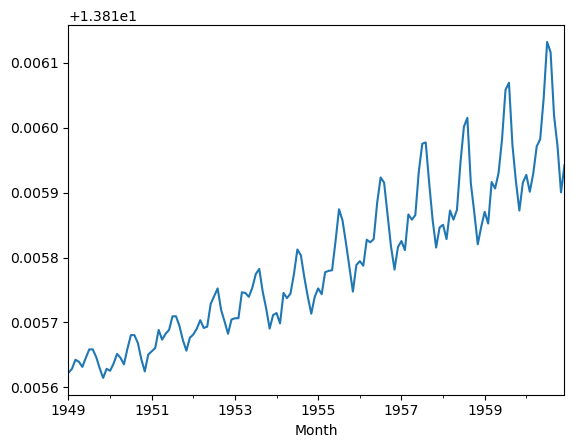

In [439]:
#but okay, if we wanna visualize...
#we wanna plot the actuals:
y_log.plot();

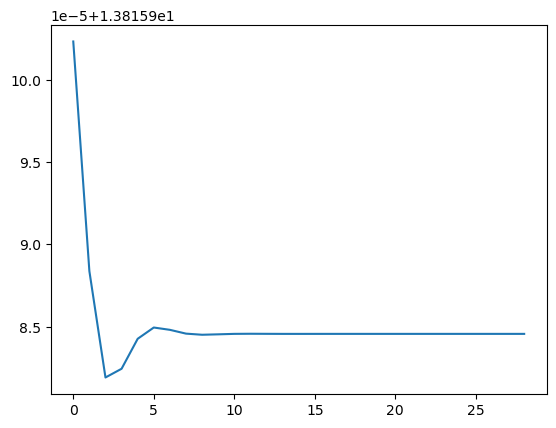

In [441]:
#one way to do is vs. the forecast for the 29 test points
plt.plot(forecast);

In [442]:
#the other option is to look at the hard-worked PREDICTIONS of the 29 test points
#that we got in the ONE-STEP method!
########################################################
split = int(.8*len(y))
train, test = y_log[:split], y_log[split:]

predictions = [] #to hold/store the predicted test points
past = list(train) #starting point for step-wise predictions, one point at a time ###GOTTA HAVE THIS HERE CUZ FOR *EACH* NEW P,D,Q, IT'S GOTTA *RESTART* AT BEING *JUST* THE ORIGINAL TRAINING DATA!!!!!!!! originally mistakenly had it outside loop/above so never reset! was just adding to it!

for i in range(len(test)):#step-wise predicts each, next/one-step-ahead point based on all the others BEFORE it!
    model = ARIMA(past, order=(2,1,1))#set up model, w/ pdq order params, and data to be trained on WHICH WILL BE UPDATED WITH +1 MORE/RECENT/LAST POINT in each of these sub-iterations aka for each pdq combo, representing for each new point to be predicted!
    result = model.fit()#train/fit model on given training data
    next_point_prediction = result.forecast()[0]
    predictions.append(next_point_prediction)
    past.append(test[i])#very important to include this because this sets up the NEXT guy w/ one more additional point for its predict; lol it's the right answer for what we were just tryna predict!

predictions

[13.816002356495192,
 13.81600612097407,
 13.815876475450361,
 13.815875621630369,
 13.815820982260178,
 13.815874024747155,
 13.815885440703651,
 13.815846794745164,
 13.815936148237318,
 13.815896385771666,
 13.815933715214774,
 13.815990072307752,
 13.81606928458762,
 13.81605269740492,
 13.81593139388842,
 13.81590773228191,
 13.81586675527088,
 13.815943380447953,
 13.815936712837816,
 13.815895744833346,
 13.815941505241147,
 13.815981455037946,
 13.815977016982233,
 13.816055323863093,
 13.816144550990767,
 13.816088414563472,
 13.815975962670418,
 13.815973834366302,
 13.815891555531014]

In [ ]:
#noyce!

In [ ]:
#in order for us to plot these either of these - lump forecast or one-by-one predictions - on the SAME graph
#as each other, gotta have DATETIME INDEXES FOR THESE!
#btw ofc we can include the best fit of the actual, like TRAINING portion!

In [455]:
#okay first let's try w/ simple/LUMP forecast:

#basically just use the y_log TEST as starting template, and REPLACE the vals w/ the FORECAST! and KEEP the
#datetime stamp index!

forecast_simple = test.copy()
for i in range(len(test)):
    forecast_simple[i] = forecast[i]
forecast_simple

Month
1958-08-01    13.816002
1958-09-01    13.815988
1958-10-01    13.815982
1958-11-01    13.815982
1958-12-01    13.815984
1959-01-01    13.815985
1959-02-01    13.815985
1959-03-01    13.815985
1959-04-01    13.815985
1959-05-01    13.815985
1959-06-01    13.815985
1959-07-01    13.815985
1959-08-01    13.815985
1959-09-01    13.815985
1959-10-01    13.815985
1959-11-01    13.815985
1959-12-01    13.815985
1960-01-01    13.815985
1960-02-01    13.815985
1960-03-01    13.815985
1960-04-01    13.815985
1960-05-01    13.815985
1960-06-01    13.815985
1960-07-01    13.815985
1960-08-01    13.815985
1960-09-01    13.815985
1960-10-01    13.815985
1960-11-01    13.815985
1960-12-01    13.815985
Name: #CigSales, dtype: float64

In [ ]:
############################################################
#yefffffff! alhamdulillah i think this is it!

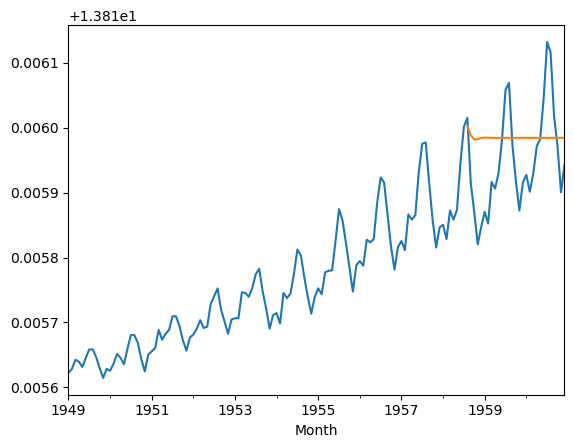

In [457]:
#now ready to plot!
fig,ax = plt.subplots()
y_log.plot(ax=ax)
#vs. the forecast
forecast_simple.plot(ax=ax);

In [ ]:
#we could even cut off the actuals for the test portion but it's good to keep so we have an idea of
#HOW GOOD THE PREDICTIONS ARE! here, doesn't look to convincing, but basically just getting at the avg which,
#at least from quick/basic look, seems to be getting it roughly right!

In [459]:
#okay cool aH now let's try our more sophisticated original onebyone forecast predictions!
forecast_advanced = test.copy()
for i in range(len(test)):
    forecast_advanced[i] = predictions[i]
forecast_advanced

Month
1958-08-01    13.816002
1958-09-01    13.816006
1958-10-01    13.815876
1958-11-01    13.815876
1958-12-01    13.815821
1959-01-01    13.815874
1959-02-01    13.815885
1959-03-01    13.815847
1959-04-01    13.815936
1959-05-01    13.815896
1959-06-01    13.815934
1959-07-01    13.815990
1959-08-01    13.816069
1959-09-01    13.816053
1959-10-01    13.815931
1959-11-01    13.815908
1959-12-01    13.815867
1960-01-01    13.815943
1960-02-01    13.815937
1960-03-01    13.815896
1960-04-01    13.815942
1960-05-01    13.815981
1960-06-01    13.815977
1960-07-01    13.816055
1960-08-01    13.816145
1960-09-01    13.816088
1960-10-01    13.815976
1960-11-01    13.815974
1960-12-01    13.815892
Name: #CigSales, dtype: float64

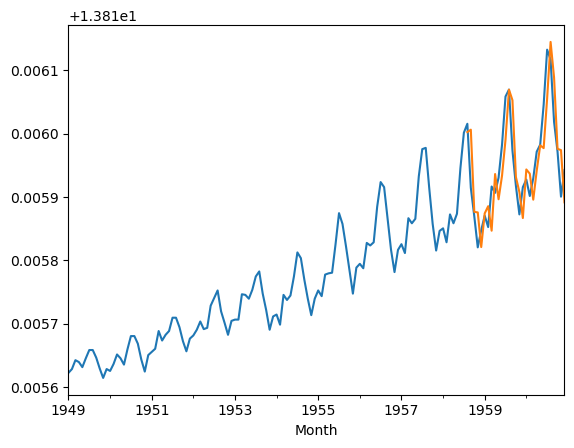

In [460]:
#dropage
fig,ax = plt.subplots()
y_log.plot(ax=ax)
#vs. the forecast
forecast_advanced.plot(ax=ax);

In [469]:
#WOW MASHALLAH VERY NICE!!!!! SUBHANALLAH LOOK AT THAT!!!!!! HOW MUCH BETTER THAT IS!!!! 1 MILLION TIMEX!!!!

# SO WHY WAS IT GIVING US THAT BAKWAAS AND SCARING US?!?!?!?!?
#but aH lol to know that LUMP forecasting is NOT the way to go!!!! so all that work WAS worth it after all!!!!

#now, we could add on the RETROACTIVE fit too! using .predict()

split = int(.8*len(y))
train, test = y_log[:split], y_log[split:]

model = ARIMA(train, order=(2,1,1))#set up model, w/ pdq order params, and data to be trained on WHICH WILL BE UPDATED WITH +1 MORE/RECENT/LAST POINT in each of these sub-iterations aka for each pdq combo, representing for each new point to be predicted!
fit = model.fit()#train/fit model on given training data
past_predictions = fit.predict() #TURNS OUT YOU *DON'T* NEED THE EXTRA '[0]' ON END LIKE THEY DID!!!! ANOTHER EXAMPLE OF THEIR CONFUSING UNNECESSARY *WASTE*!!!!!

past_predictions

1949-01-01     0.000000
1949-02-01    13.815623
1949-03-01    13.815630
1949-04-01    13.815646
1949-05-01    13.815636
                ...    
1958-03-01    13.815821
1958-04-01    13.815890
1958-05-01    13.815845
1958-06-01    13.815880
1958-07-01    13.815964
Freq: MS, Name: predicted_mean, Length: 115, dtype: float64

In [ ]:
#oh nice! already in format we want!!!!

#OH! notice bottom says 'frequency: MS' - GUESSING THAT'S *MONTHS*!!! even tho in equation code thought it was just freq='M'?
#but 'MS' kept showing up in errors and was thinking it had to do w/ MA moving average, but makes sense now cuz also kept seeing
#/getting message of FREQUENCY NOT SPECIFIED SO ASSUMED!!! didn't realize they were/musta been SAMES!

In [479]:
####################################
####ohhhhh shoot though! we could also do back predictions
#as/from the FULL/WHOLE dataset like we did in noob best fit!

#no need for train/test split obvy!

model_full = ARIMA(y_log, order=(2,1,1))#set up model, w/ pdq order params, and data to be trained on WHICH WILL BE UPDATED WITH +1 MORE/RECENT/LAST POINT in each of these sub-iterations aka for each pdq combo, representing for each new point to be predicted!
fit_full = model_full.fit()#train/fit model on given training data
past_predictions_full = fit_full.predict() #TURNS OUT YOU *DON'T* NEED THE EXTRA '[0]' ON END LIKE THEY DID!!!! ANOTHER EXAMPLE OF THEIR CONFUSING UNNECESSARY *WASTE*!!!!!

past_predictions_full

1949-01-01     0.000000
1949-02-01    13.815623
1949-03-01    13.815630
1949-04-01    13.815644
1949-05-01    13.815637
                ...    
1960-08-01    13.816143
1960-09-01    13.816082
1960-10-01    13.815968
1960-11-01    13.815961
1960-12-01    13.815891
Freq: MS, Name: predicted_mean, Length: 144, dtype: float64

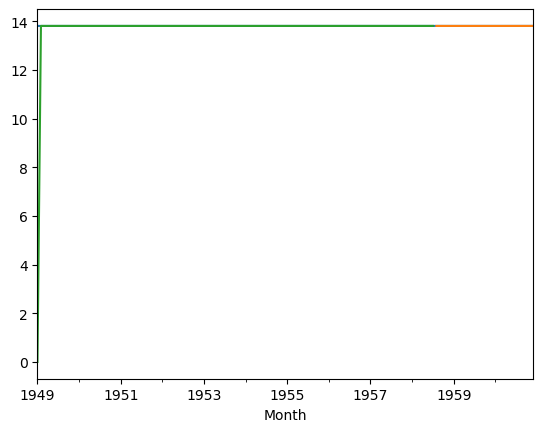

In [472]:
fig,ax = plt.subplots()
#actuals
y_log.plot(ax=ax)
#forecast
forecast_advanced.plot(ax=ax)
#'retroactive' forecast aka *BE*FOREcast! ;P
past_predictions.plot(ax=ax);

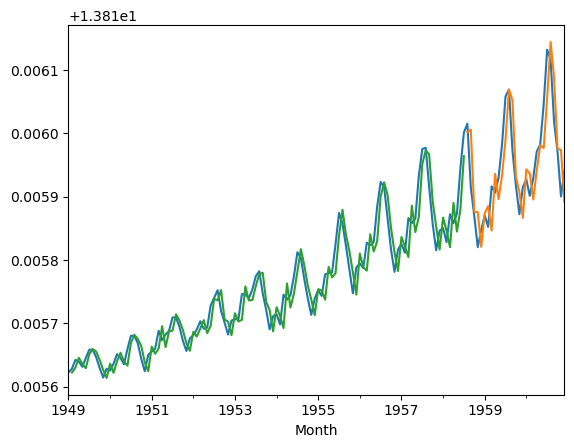

In [480]:
#oh, ubb - actually i think we saw this / this was why they start at like the 2nd/3rd point, index[2]?!?!?!
##############################################################################################################
fig,ax = plt.subplots()
#actuals
y_log.plot(ax=ax)
#forecast
forecast_advanced.plot(ax=ax)
#'retroactive' forecast aka *BE*FOREcast! ;P
past_predictions[1:].plot(ax=ax);

In [ ]:
#SUBHANALLAHI WA BI HAMDI SUBHANALLAHIL 'AUDHEEM!!!!!!!!!

In [ ]:
#would be good to add color legend

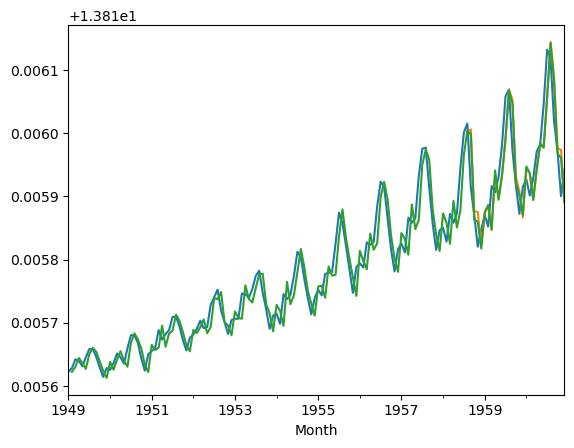

In [485]:
#W/FULL!
#this would let us see the best fit for the WHOLE, so here,
#wouldn't make alotta sense to also look at the TEST predictions aka FORECASTS one-steps too
#occluded anyway!

fig,ax = plt.subplots()
#actuals
y_log.plot(ax=ax)
#forecast
forecast_advanced.plot(ax=ax)
#full fit
past_predictions_full[1:].plot(ax=ax);

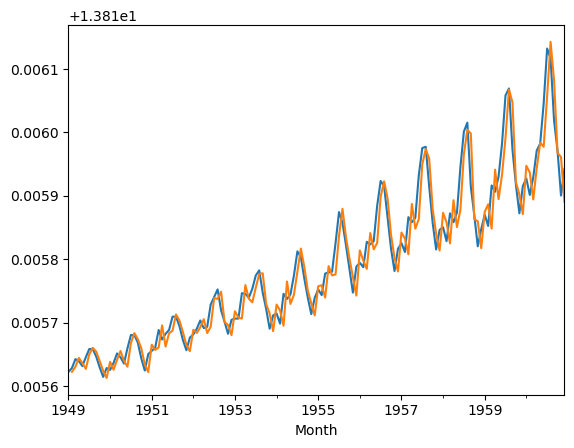

In [486]:
#here it is without test predictions
#W/FULL!

fig,ax = plt.subplots()
#actuals
y_log.plot(ax=ax)
#full fit
past_predictions_full[1:].plot(ax=ax);

In [ ]:
#Alhamdulillahi Rabbil 'Aalameen!

In [ ]:
#NOTE that w/ one-step NON-lump forecast we CAN'T go into the future indefinitely, only - obvy - ONE step further than past!
#lump forecasting can be used for beyond that. OH! maybe it makes sense that lump straightens out to STRAIGHT LINE really quick
#CUZ TOO MUCH UNCERTAINTY!!! like we talked about! - think it's that thing! too difficult to predict SPECIFICS but/so can only predict
#basically moving AVERAGE! or like not even moving lol just like overall 'future' average - remember encountering this

################################################################################################################################

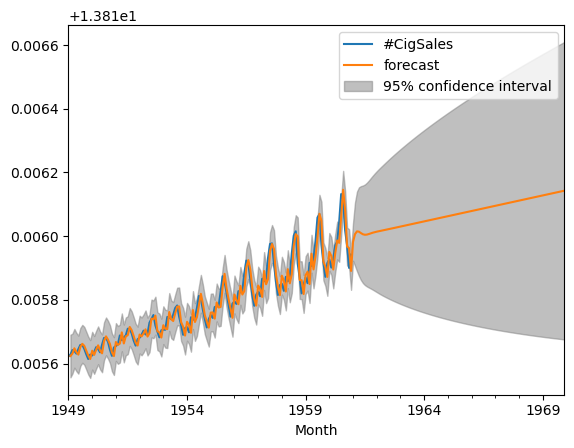

In [464]:
#now lets go back to the orignal idea of plot predict!

#so wait, w/ plot_predict we CAN predict out into future for where we don't have data - so like here for our 1961-1970 period...
#BUT SO WE *DON'T* HAVE TO USE 'LUMP FORECAST' THEN?!?!!?


model = ARIMA(y_log, trend='t', order=(2,1,1))
fit = model.fit()
fig, ax = plt.subplots()
y_log.plot(ax=ax) #actuals
plot_predict(fit, start='1949-02-01', end='1969-12-01', ax=ax)#, freq='M') #predictions #can choose to BACK predict too, or we can use our house .predict()?!
plt.show() #need this or else duplicates for some reason?? maybe cuz subplots?

In [ ]:
#hmmm, could we have just used plot_predict off of training fit to give us predictions in test, in the last section?
#or would that have been like using LUMP forecast?

In [ ]:
#we can of course take out the BEFOREcast lol if we want and START @ '1961-01-01'!!!!
#but yeah this is basically just a TRENDLINE up!!!!
#it's like it's CONTINUING the moving average line!!! AKA JUST LIKE A BEST FIT!!!!!!!
#could add trendline over existing/actuals/'to-date'
##########################################################################################

In [ ]:
#btw when you look at the warnings which we suppressed, was confusing
#like about frequency, assuming it, even when i set to 'M' for month

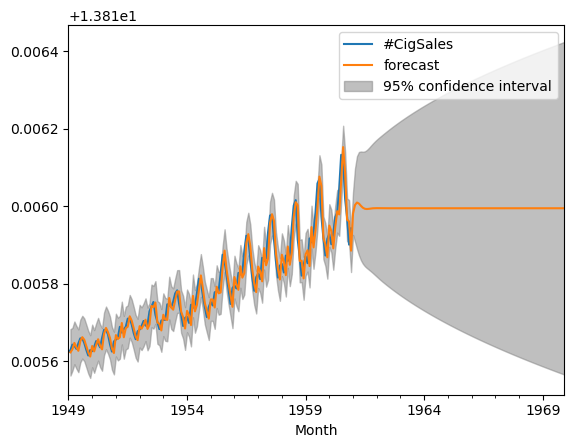

In [37]:
#let's try tweaking to see if that changes anything
#take out trend='t'

model = ARIMA(y_log, order=(2,1,1))
fit = model.fit()
fig, ax = plt.subplots()
y_log.plot(ax=ax) #actuals
plot_predict(fit, start='1949-02-01', end='1969-12-01', ax=ax);#, freq='M') #predictions #can choose to BACK predict too, or we can use our house .predict()?!


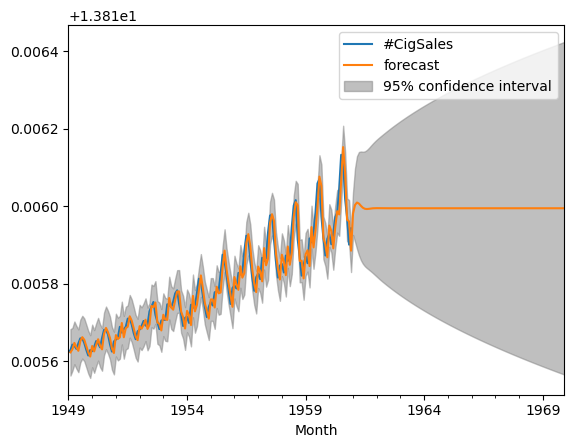

In [38]:
#oh, ok, well, seems the same! so no need for 't', maybe that's default!
#let's see if bringing in 'M' does anything

model = ARIMA(y_log, order=(2,1,1))
fit = model.fit()
fig, ax = plt.subplots()
y_log.plot(ax=ax) #actuals
plot_predict(fit, start='1949-02-01', end='1969-12-01', ax=ax, freq='M'); #predictions #can choose to BACK predict too, or we can use our house .predict()?!


In [ ]:
#hmm, still seems same, so SCRAP IT!

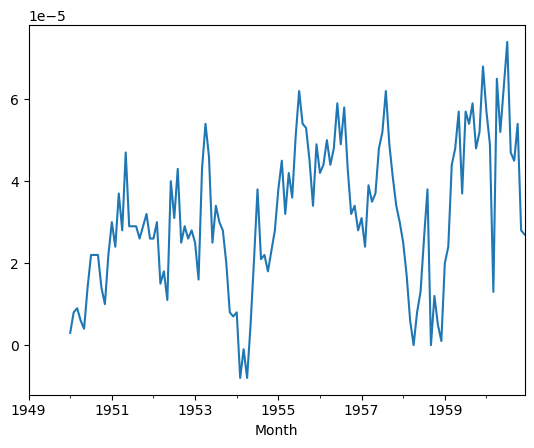

In [40]:
#BTW!!!!! does the optimal d being 1 have anything to do with / like makes sense cuz we did first differences
#and THAT DID INDEED THAT ELIMINATED THE NON-STATIONARITY AND MADE IT STATIONARY!!!
#but,... WHAT WOULD HAPPEN IF WE LOOKED AT *12TH* DIFFERENCES!?
##################################################################################################

np.log(y).diff(12).plot();


In [ ]:
#hmmmmm, interesting. looks like we never actually did this kinda plot before...
#i did manually look at like diff(4) to check what happened w/ the beginning offsetting/blanks for seasonal
#/quarterly numbers for seasonality, but i guess this is diff than correlation?... or actually,... is it?
#like what we should see is that if we're taking the 12th difference, then all these are the differences between
#THE SAME MONTH in two consecutive/back-to-back years
#so if things were constant, like maybe if it was ADDITIVE?? then it'd be like a FLATTISH line, w/ just random noise
#pushing it out
#but maybe cuz this is GROWING/GLOWING/BLOWING UP/THROBBING SEASONAL SWINGS/AMPLITUDE OVER TIME, the GENERAL
#TREND/DIFFERENCES ARE GOING UP OVER TIME!!!!
#there are the 2-4 big low differences, but noticed they're plotted shifted ONE YEAR OVER, so plotted on dates
#/months/periods of one year after! cuz gotta be one of the 2 dates in the difference!
####################################################################################################

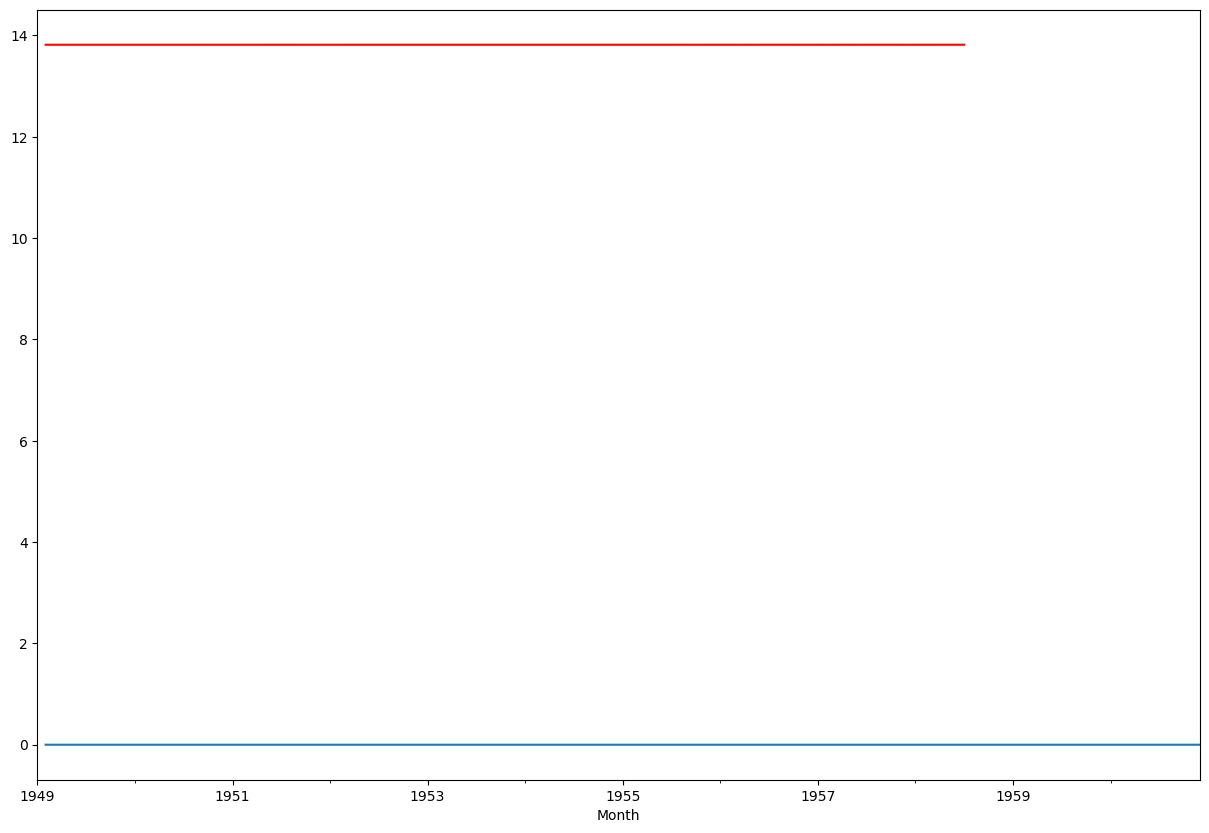

In [475]:
#oh interesting! they also plotted the WHITE NOISE, aka DIFF'D data!
plt.figure(figsize=(15,10))
y_log.diff().plot()
# plt._ _ _(model_fit.predict(), color = 'red')
past_predictions[1:].plot(c='r'); #oh yeah lol better take out 1st!

In [ ]:
#oh wait yeah... what are they thinking putting DIFFERENCES on here?! totally different SCALE!!!
#unless maybe we go back to NON-logged, but think that'll be same thing. would have to redo everything as that
#oh wait no, couldn't be cuz they themselves show it's Y_LOG.DIFF()!!!!!!

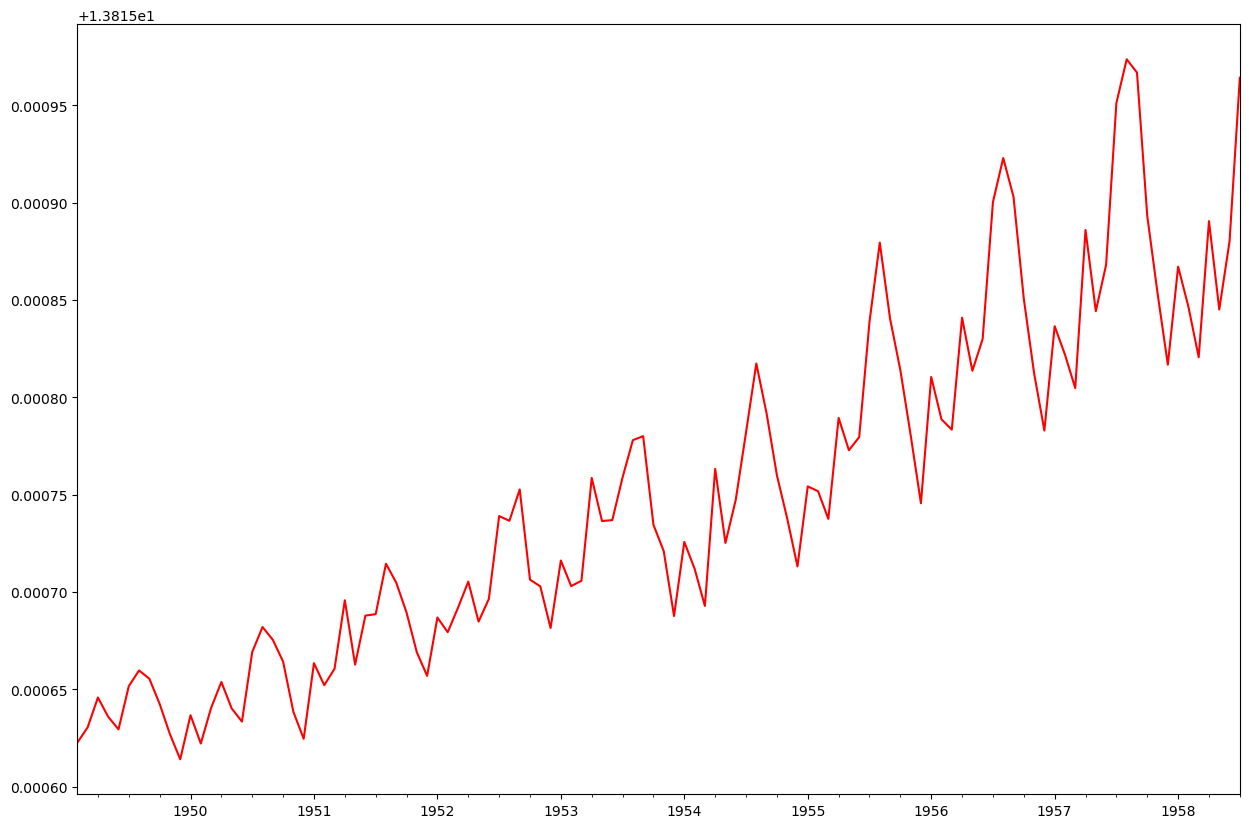

In [476]:
#better we look at these SEPARATELY!
#oh interesting! they also plotted the WHITE NOISE, aka DIFF'D data!
plt.figure(figsize=(15,10))
past_predictions[1:].plot(c='r'); #oh yeah lol better take out 1st!

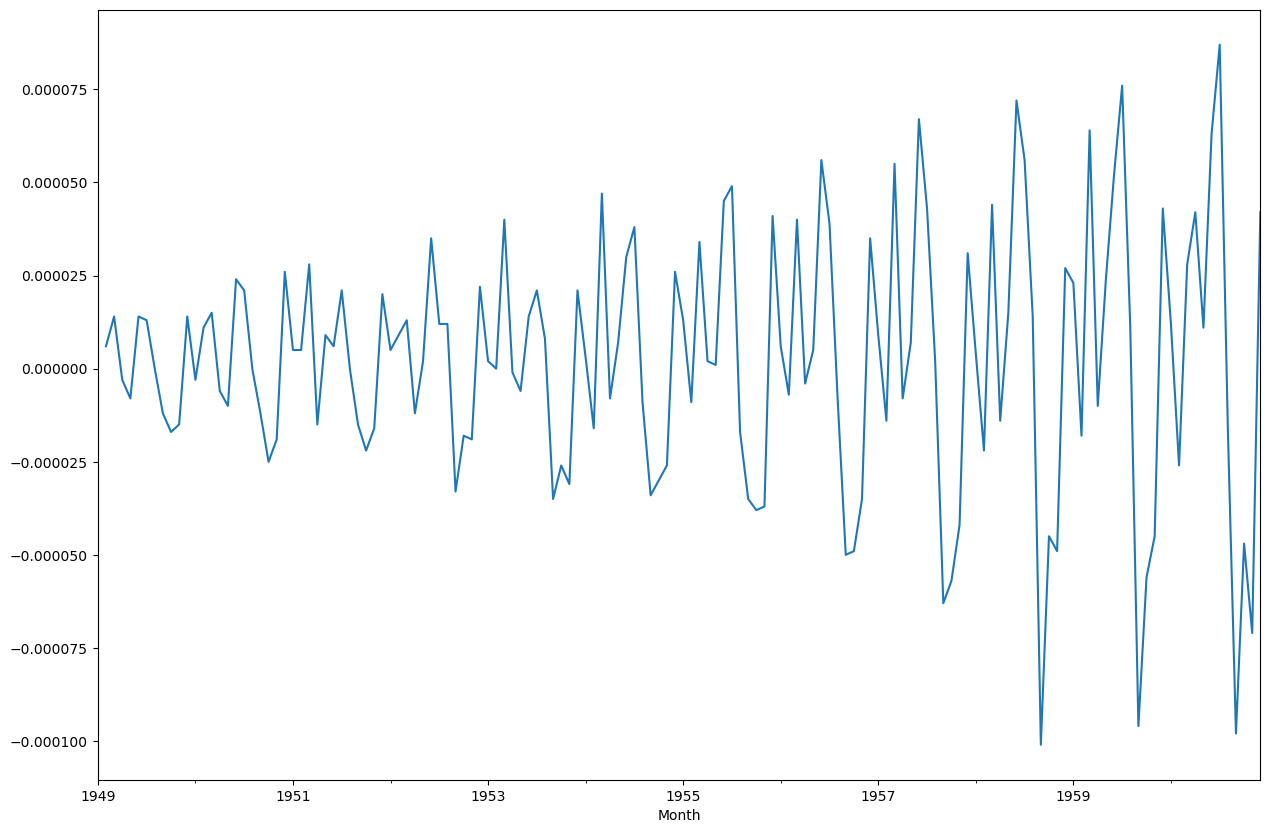

In [478]:
plt.figure(figsize=(15,10))
y_log.diff().plot();

In [ ]:
#so yeah, weird they'd have us put diffs on same plot?

#funny they don't even USE their lump forecast here!!! but i guess not looking ahead yet... that's prob next

#but lol they didn't even plot the back_predictions against the ACTUALS!!!

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [487]:
#yep, we did get really close to actuals in past_predict!best fit!
#there's AIC/BIC but to see best fit/goodness of fit metric w/ MSE, we could do w/ .PREDICT() right?!
#on the FULL!
########################################################################################################################
# split = int(.8*len(y))
# train, test = y_log[:split], y_log[split:]

# model = ARIMA(train, order=(2,1,1))
# fit = model.fit()
# past_predictions = fit.predict() 
# mean_squared_error(train,past_predictions)


#oh wait - ^that was only for TRAIN portion, but we'd wanna do it on FULL fit

########################################################################################################################

#same as original, copied here!

model_full = ARIMA(y_log, order=(2,1,1))
fit_full = model_full.fit()
past_predictions_full = fit_full.predict()

mean_squared_error(y_log,past_predictions_full)

1.3254960181789972

In [430]:
#hmmm, isn't that like actually pretty bad? like compared to the other ones that had mse's of e-9??????
########################################################################################################################
predictions

1949-01-01     0.000000
1949-02-01    20.723434
1949-03-01    13.815635
1949-04-01    13.815655
1949-05-01    13.815627
                ...    
1958-03-01    13.815823
1958-04-01    13.815903
1958-05-01    13.815833
1958-06-01    13.815904
1958-07-01    13.815988
Freq: MS, Name: predicted_mean, Length: 115, dtype: float64

In [ ]:
#hmmm okay, still not that great, though better (over doing on train)

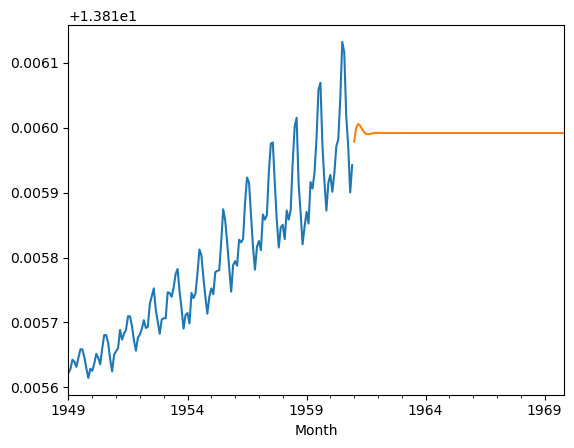

In [488]:
#okay so now they're talking about future forecasting. we already did
#again, only options in our situation are lump forecast from full existing fit, or PLOT_PREDICT!

#so we could do the 2,1,1 LUMP forecast for comparo?

lump_forecast = fit_full.forecast(107) #i think that's right #months we're looking to forecast >> just shy of *9 YEARS*
#Jan 1961 thru Dec 1969

fig,ax = plt.subplots()
y_log.plot(ax=ax)
#vs. the forecast
lump_forecast.plot(ax=ax);

In [ ]:
#khe khe khe - kinda boring, flat lol. seen

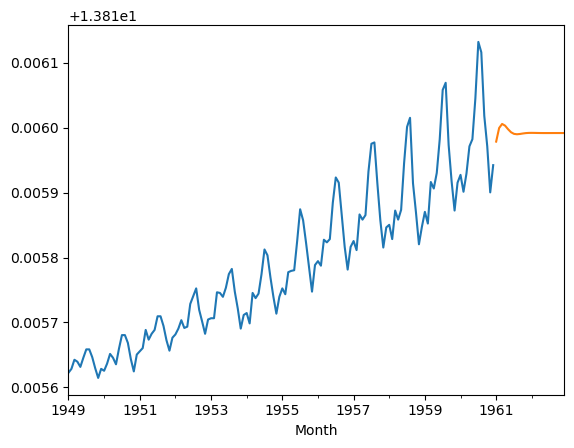

In [489]:
#THEIRS / ONLY 2 YEARS!

#okay so now they're talking about future forecasting. we already did
#again, can't 

#so we could do the 2,1,1 LUMP forecast for comparo?

small_forecast = fit_full.forecast(24)

fig,ax = plt.subplots()
y_log.plot(ax=ax)
#vs. the forecast
small_forecast.plot(ax=ax);

In [ ]:
#oh... hmmm, the line looks like the same exact levelling-out/equilibrium line... thought maybe it'd be lower cuz thought like the line
#represents the AVERAGE over that period!!!
############################################################################################################################################

In [ ]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast

#so like Jan 1961 to Dec 1969

# Convert that range into a dataframe that includes your predictions
#make df out of this date range & lump predictions like we just did^, then shove the datetimes into/as INDEX!

# Plot your future predictions
#above

In [ ]:
#BUT WHY DIDN'T THEY USE THE BUILT-IN PLOT_PREDICT?!?

#okay so they only made lump forecast intending to / for FUTURE predictions, but yeah, that's what we use LUMP for!
#but lump is just STRAIGHT like avg/single value basically while plot_predict gives us a MOVING AVG continuation/'best fit line'!!!!

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

In [ ]:
#okay so yeah this/THEIR simple way is basically just the AVERAGE line for i guess what's expected over the next 10 years!
#oh, but from plotting BOTH their 2 year and my 10 year lump forecast, line levels look same??

#but yeah aH they agree w/ my reasoning! summer weather/winter cold etc. but interesting thought about perhaps more/less spending/disposable income,
#i'd say based on *MOOD*! sun = feel good/good mood = spend more :D does marketing exploit this??

#yeah and all this again was just from ONE VARIABLE!!!!! just the target variable ITSELF!!!! like how in gdata simplest way to go
#when in doubt for prediction, JUST GO W/ FOR THE *AVERAGE*!!!
#but clearly this isn't the OVERALL average, but maybe like the average of the *LAST *YEAR**?!?!??!!?!?
######################################################################################################

#"We could suggest to our customers that, if they are interested in discovering the causes of the cigarette sales trajectory,
#they execute a regression analysis in addition to the time series one."